<a href="https://colab.research.google.com/github/liminal-learner/Chaos/blob/master/SalaryPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictions Based on Job Descriptions

#DEFINE

### ---- 1 Define the problem ----

#### The task is to build a model that predicts job salaries based on relevant features of job postings. The goal is to get the MSE down to at most 360. 

In [0]:
#import your libraries
import pandas as pd
import sklearn as sk
import matplotlib as plt
from scipy import stats
import seaborn as sns
import numpy as np
import io
import pickle
import csv

#your info here
__author__ = "heather"

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import PolynomialFeatures

from google.colab import files
#import xgboost as xgb

#from sklearn.grid_search import GridSearchCV

In [0]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (7, 5)   # figure size in inches
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', 500)

In [0]:
def clean_data(feature_data, target_data):
    # Want to detect and drop the whole row for those missing the target variable 'salary'
    inds_to_drop = target_data.loc[target_data['salary']==0].index

    target_data.drop(inds_to_drop, axis = 0, inplace = True)
    feature_data.drop(inds_to_drop, inplace = True, axis=0)
    
    return [feature_data, target_data]


def join_features_with_target(feature_data,target_data,unique_identifier):
    return pd.concat([feature_data.set_index(unique_identifier),target_data.set_index(unique_identifier)],join='inner',axis=1)
    

In [0]:
def dummy_encode(feature_data,categorical_vars):
   
    for cat_var in categorical_vars:
        dummies = pd.get_dummies(feature_data[cat_var],prefix=cat_var.upper())
        feature_data = pd.concat([feature_data,dummies],join='inner',axis=1)
    return feature_data

def set_ordinal_levels(ordinal_data,ordered_categories):
    levels_dict = dict(enumerate(ordered_categories))
    levels_dict = dict(zip(levels_dict.values(),levels_dict.keys()))

    return ordinal_data.apply(lambda x: levels_dict[x])
    
    # For newer versions of scikitlearN:
    #oe = OrdinalEncoder(categories=[ordered_categories])
    #return oe.fit_transform(ordinal_data)


In [0]:
def engineer_features(feature_data, target_data, categorical_vars, unique_identifier):
    
    # Do this first so that we can use the group statistics of the target
    features_target_joined = join_features_with_target(feature_data, target_data, unique_identifier)

    # Bin the companies into four groups (quartiles) based on the mean salary of each company
    company_group_dict = dict(pd.qcut(features_target_joined.groupby('companyId')['salary'].mean(), 4, labels=False))
    feature_data['COMPANY_BIN'] = feature_data['companyId'].apply(lambda x: company_group_dict[x])

    # Create group statistics for everything else
    for var in categorical_vars:
        group_stats = features_target_joined.groupby(var)['salary'].describe()
        # Abbreviate the name: 
        new_columns = [var[0:4].upper()+'_'+x for x in group_stats.columns]
        group_stats.columns=new_columns
        feature_data = feature_data.join(group_stats,on=var,how='left')
    
    # Add the new features to the joined df as well:
    features_target_joined = join_features_with_target(feature_data, target_data, unique_identifier)

    return [feature_data, features_target_joined]

def transform_target(target_data,target_name):
    target_data['square_root_target'] = target_data[target_name].apply(lambda x: x**(1/2))
    return target_data


In [0]:
def preprocess_data(feature_data, target_data, target_name, categorical_vars, nominal_vars_to_encode, ordinal_vars_to_encode, unique_identifier):
    feature_data, target_data = clean_data(feature_data, target_data)

    # Encode nominal variables:
    feature_data = dummy_encode(feature_data, nominal_vars_to_encode)
    
    # Encode ordinal variables: (Next time use label encoder)
    ordered_categories = [['NONE','HIGH_SCHOOL','BACHELORS','MASTERS','DOCTORAL']]
    for (ind, var) in enumerate(ordinal_vars_to_encode):
        new_name = (var+'_code').upper()
        feature_data[new_name] = set_ordinal_levels(feature_data[var], ordered_categories[ind])
    
    # Baseline features to model exclude the unique identifier and only include 
    # the encoded versions of the categorical variables that were specified.
    excluded_base_features = set([unique_identifier] + nominal_vars_to_encode + ordinal_vars_to_encode)
    base_features = set(feature_data.columns) - excluded_base_features
    
    # Engineer features
    target_data = transform_target(target_data, target_name)
    feature_data, features_target_joined = engineer_features(feature_data, target_data, categorical_vars, unique_identifier)
    
    engineered_features = set(feature_data.columns) - base_features - excluded_base_features

    return [feature_data, base_features, engineered_features, target_data, features_target_joined]



In [0]:
def select_features_to_model(feature_data, list_of_features):
  return feature_data[list_of_features]

In [0]:
def calcANOVA(grouped, target_name):
    """A helper function to calculate ANOVA using each level of a categorical variable with every other level. 
    Note each comparison is made twice. Future version will eliminate the redundancy. 
    Assumes the target has been joined to the features dataframe that is passed"""
    keys = list(grouped.groups.keys())
    levels = [grouped.get_group(key)[target_name] for key in grouped.groups.keys()]
    
    for ind, level in enumerate(levels):
        other_levels = levels[:ind]+levels[ind+1:]
        other_keys = keys[:ind]+keys[ind+1:]
        for k, other_level in enumerate(other_levels):    
            f_val, p_val = stats.f_oneway(level,other_level)
            print( "ANOVA results for ",keys[ind]," and ",other_keys[k],": F=", f_val, ", P =", p_val)   

In [0]:
def plot_distributions(original,modified):
    fig = plt.pyplot.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(121)
    original.plot.hist(ax=ax1,bins=20);
    plt.pyplot.xlabel(original.name, fontsize=12)
    plt.pyplot.title('BEFORE', fontsize=24)

    ax2 = fig.add_subplot(122)
    modified.plot.hist(ax=ax2,bins=20);
    plt.pyplot.xlabel(modified.name, fontsize=12)
    plt.pyplot.title('AFTER', fontsize=24)
    
    plt.pyplot.show()

In [0]:
class baseline_predictor:
    """Takes X, y and makes predictions based on the mean target when grouped by the baseline_feature.
    Assumes y has two columns or an index and a column containing the target variable. Assumes X also has
    a matching index column and a columns containing the baseline_feature."""

    
    # Need these to be compatible with scikit-learn's cross validation methods:
    def get_params(self, deep=True):
        # no hyperparameters for this estimator
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self,X,y,index_name,target_name,baseline_feature):
        self.baseline_feature = baseline_feature
        self.index_name = index_name
        
        y = y.reset_index().set_index(self.index_name)
        X = X.reset_index().set_index(self.index_name)

        df = pd.concat([X,y],join='inner',sort=False,axis=1)
        self.baseline_avg = df.groupby(self.baseline_feature)[target_name].mean()

    def predict(self,X):
        return X.apply(lambda X_row: self.baseline_avg[X_row[self.baseline_feature]],axis=1)

In [0]:
def calcMSE_polynomial(X,y):
    pr = PolynomialFeatures(degree=2)
    Z_pr = pr.fit_transform(X)

    # fit the polynomial features
    lm.fit(Z_pr,y)

    yhat = sk.model_selection.cross_val_predict(lm,Z_pr,y,cv=5)
    return mean_squared_error(y,yhat)

In [0]:
def evaluate_model(model, X, y):
    #model.fit(X,y)
    yhat = sk.model_selection.cross_val_predict(model,X,y,cv=5)
    return [mean_squared_error(y,yhat), model]

In [0]:
def evaluate_rf_hyperparams(hyperparam,vals,X,y):
    oob = []
    train_score=[]
    params = {'oob_score': True, 'n_jobs': -1, 'random_state': 55, 'n_estimators': 20, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3}

    for val in vals:
        params[hyperparam] = val
        rf = RandomForestRegressor(**params)
        rf.fit(X,y)

        # Wanted to compare overall score on training set to oob score but way too slow.
        # print(rf.score(X_sample,y_sample))
        # train_score.append(rf.score(X_sample,y_sample))

        oob.append(rf.oob_score_)
    return oob
    

In [0]:
def plot_oob(hyperparam, vals, oob_scores):
    plt.pyplot.plot(vals, oob_scores);
    plt.pyplot.xlabel(hyperparam);
    plt.pyplot.ylabel('OOB Score');


In [0]:

nominal_vars = ['companyId','jobType','major','industry']
ordinal_vars = ['degree']
categorical_vars = nominal_vars+ordinal_vars
numerical_vars = ['yearsExperience','milesFromMetropolis']
target_name = 'salary'
unique_identifier = 'jobId'

#DISCOVER

### ---- 2 Load the data ----

In [18]:
from google.colab import files
uploaded = files.upload()


Saving train_salaries.csv to train_salaries (1).csv
Saving train_features.csv to train_features (1).csv
Saving test_features.csv to test_features (1).csv


In [0]:
def load_data(train_features,test_features,train_target):
  return [pd.read_csv(train_features),pd.read_csv(test_features),pd.read_csv(train_target)]



### ---- 3 Clean the data ----

In [0]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [0]:
train_features.shape

(1000000, 8)

In [0]:
train_features.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

### Look for missing & invalid data

In [0]:
missing_data = train_features.isnull().sum()
missing_data

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [0]:
missing_data = train_salaries.isnull().sum()
missing_data

jobId     0
salary    0
dtype: int64

In [0]:
# Job Id's should be unique
train_features.shape[0] == len(train_features['jobId'].unique())

True

In [0]:
train_features.shape[0] == len(train_salaries['jobId'].unique())

True

In [0]:
all(train_features['yearsExperience'] >= 0)

True

In [0]:
all(train_features['milesFromMetropolis'] >= 0)

True

In [0]:
# Want to see if any salaries are zero in the train set because this indicates a missing target variable
all(train_salaries['salary'] > 0)

False

In [0]:
train_salaries[train_salaries['salary']==0]

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [0]:
train_features, train_salaries = clean_data(train_features, train_salaries)
len(train_features)

999995

### Set levels of ordinal features & get dummies for nominal features

In [0]:
# Don't want to encode company ID, because we have seen the groups do not generally vary in a statistically significant way.
train_features = dummy_encode(train_features, nominal_vars[1:-1])
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,JOBTYPE_CEO,JOBTYPE_CFO,...,JOBTYPE_VICE_PRESIDENT,MAJOR_BIOLOGY,MAJOR_BUSINESS,MAJOR_CHEMISTRY,MAJOR_COMPSCI,MAJOR_ENGINEERING,MAJOR_LITERATURE,MAJOR_MATH,MAJOR_NONE,MAJOR_PHYSICS
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,0,1,...,0,0,0,0,0,0,0,1,0,0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,1,0,...,0,0,0,0,0,0,0,0,1,0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,0,0,...,1,0,0,0,0,0,0,0,0,1
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,0,0,...,0,0,0,1,0,0,0,0,0,0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,0,0,...,1,0,0,0,0,0,0,0,0,1


In [0]:
degree_levels = ['NONE','HIGH_SCHOOL','BACHELORS','MASTERS','DOCTORAL']
train_features['degree_code'] = set_ordinal_levels(train_features['degree'],degree_levels)
ordinal_encoded = ['degree_code']
train_features.head()

### ---- 4 Explore the data (EDA) ----

### Summarize the variables

In [0]:
train_features[categorical_vars].describe()

,companyId,jobType,major,industry,degree
count,999995,999995,999995,999995,999995
unique,63,8,9,7,5
top,COMP39,SENIOR,NONE,WEB,HIGH_SCHOOL
freq,16193,125886,532353,143205,236975


In [0]:
train_features[numerical_vars].describe()

,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000
mean,11.992407,49.529381
std,7.212390,28.877721
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [0]:
train_salaries.describe()

,salary
count,999995.000000
mean,116.062398
std,38.717163
min,17.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


In [0]:
# Join the target with the feature table so that we can see correlations

train_target_joined = join_features_with_target(train_features,train_salaries,unique_identifier)
len(train_target_joined)

999995

In [0]:
train_target_joined.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,JOBTYPE_CEO,JOBTYPE_CFO,JOBTYPE_CTO,...,MAJOR_BUSINESS,MAJOR_CHEMISTRY,MAJOR_COMPSCI,MAJOR_ENGINEERING,MAJOR_LITERATURE,MAJOR_MATH,MAJOR_NONE,MAJOR_PHYSICS,degree_code,salary
jobId,,,,,,,,,,,,,,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,0,1,0,...,0,0,0,0,0,1,0,0,3,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,1,0,0,...,0,0,0,0,0,0,1,0,1,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,0,0,0,...,0,0,0,0,0,0,0,1,4,137
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,0,0,0,...,0,1,0,0,0,0,0,0,4,142
JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,0,0,0,...,0,0,0,0,0,0,0,1,2,163


### Correlations

In [0]:
cr = train_target_joined.corr()

In [0]:
# Just for sorting to see largest correlations first
cr['abs_salary_corr'] = abs(cr['salary'])

In [0]:
cr.sort_values(by=['abs_salary_corr'],ascending=False)

,yearsExperience,milesFromMetropolis,JOBTYPE_CEO,JOBTYPE_CFO,JOBTYPE_CTO,JOBTYPE_JANITOR,JOBTYPE_JUNIOR,JOBTYPE_MANAGER,JOBTYPE_SENIOR,JOBTYPE_VICE_PRESIDENT,...,MAJOR_CHEMISTRY,MAJOR_COMPSCI,MAJOR_ENGINEERING,MAJOR_LITERATURE,MAJOR_MATH,MAJOR_NONE,MAJOR_PHYSICS,degree_code,salary,abs_salary_corr
salary,0.375013,-0.297686,0.285246,0.188803,0.189608,-0.441676,-0.201987,-0.006778,-0.103650,0.090947,...,0.084044,0.102986,0.144203,0.053918,0.110413,-0.371435,0.092056,0.384044,1.000000,1.000000
JOBTYPE_JANITOR,-0.001192,-0.001120,-0.142694,-0.142427,-0.142868,1.000000,-0.142572,-0.142917,-0.143417,-0.142992,...,-0.094523,-0.094102,-0.094283,-0.094360,-0.093603,0.354202,-0.094126,-0.349267,-0.441676,0.441676
degree_code,0.000217,0.001785,0.050380,0.049126,0.050040,-0.349267,0.049431,0.049052,0.051131,0.050062,...,0.207797,0.206437,0.206852,0.208271,0.206369,-0.779355,0.207568,1.000000,0.384044,0.384044
yearsExperience,1.000000,0.000672,0.000307,-0.000103,0.000967,-0.001192,-0.000001,-0.000269,0.000222,0.000068,...,-0.000597,-0.000460,-0.000156,0.000643,-0.000005,0.000110,-0.000269,0.000217,0.375013,0.375013
MAJOR_NONE,0.000110,-0.001626,-0.050958,-0.050205,-0.050948,0.354202,-0.049764,-0.050402,-0.052190,-0.049690,...,-0.266862,-0.265672,-0.266184,-0.266401,-0.264263,1.000000,-0.265740,-0.779355,-0.371435,0.371435
milesFromMetropolis,0.000672,1.000000,-0.000666,0.000566,0.000674,-0.001120,0.001713,-0.000406,0.000567,-0.001325,...,0.000205,0.001265,0.000417,0.001426,-0.000912,-0.001626,0.000221,0.001785,-0.297686,0.297686
JOBTYPE_CEO,0.000307,-0.000666,1.000000,-0.142301,-0.142742,-0.142694,-0.142447,-0.142791,-0.143290,-0.142866,...,0.014098,0.015541,0.012558,0.013435,0.011797,-0.050958,0.014718,0.050380,0.285246,0.285246
JOBTYPE_JUNIOR,-0.000001,0.001713,-0.142447,-0.142180,-0.142621,-0.142572,1.000000,-0.142670,-0.143168,-0.142744,...,0.013051,0.013083,0.015015,0.013610,0.013190,-0.049764,0.012325,0.049431,-0.201987,0.201987
JOBTYPE_CTO,0.000967,0.000674,-0.142742,-0.142475,1.000000,-0.142868,-0.142621,-0.142966,-0.143465,-0.143040,...,0.013793,0.014668,0.011818,0.014675,0.014514,-0.050948,0.013176,0.050040,0.189608,0.189608
JOBTYPE_CFO,-0.000103,0.000566,-0.142301,1.000000,-0.142475,-0.142427,-0.142180,-0.142524,-0.143022,-0.142598,...,0.013372,0.014204,0.013350,0.010553,0.014043,-0.050205,0.013497,0.049126,0.188803,0.188803


In [0]:
# Look for strong correlations between the variables
cr[cr.apply(lambda x: abs(x).between(0.5,0.9999).any(),axis=1)]

,yearsExperience,milesFromMetropolis,JOBTYPE_CEO,JOBTYPE_CFO,JOBTYPE_CTO,JOBTYPE_JANITOR,JOBTYPE_JUNIOR,JOBTYPE_MANAGER,JOBTYPE_SENIOR,JOBTYPE_VICE_PRESIDENT,...,MAJOR_CHEMISTRY,MAJOR_COMPSCI,MAJOR_ENGINEERING,MAJOR_LITERATURE,MAJOR_MATH,MAJOR_NONE,MAJOR_PHYSICS,degree_code,salary,abs_salary_corr
MAJOR_NONE,0.000110,-0.001626,-0.050958,-0.050205,-0.050948,0.354202,-0.049764,-0.050402,-0.052190,-0.049690,...,-0.266862,-0.265672,-0.266184,-0.266401,-0.264263,1.000000,-0.265740,-0.779355,-0.371435,0.371435
degree_code,0.000217,0.001785,0.050380,0.049126,0.050040,-0.349267,0.049431,0.049052,0.051131,0.050062,...,0.207797,0.206437,0.206852,0.208271,0.206369,-0.779355,0.207568,1.000000,0.384044,0.384044


#### From this, we see that:
* The job type **'JANITOR'** offers the highest negative correlation to salary (-0.442) 
* Meanwhile, **'CEO'** is weakly positively correlated with salary (0.285) followed by most other levels of **job type**
* The ordinal feature **degree code** offers the next greatest (weak) correlation with salary (0.384), then **years of experience** (0.375)
* Having **no major** is weakly negatively correlated to salary (-0.371), and strongly negatively correlated with degree code (-0.779): in other words, having no degree (low-level degree_code) is correlated with having no major. 
* **Miles from metropolis** is also weakly negatively correlated to salary (-0.298)
* The levels of **industry** and **major** are very weakly correlated with salary (<0.18, except for no major), while **company** is not (<0.003)

### Continuous Variables
#### Regression plots:

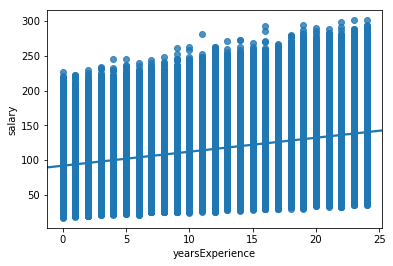

In [0]:
sns.regplot(x='yearsExperience',y='salary',data=train_target_joined)

* **There is a positive roughly linear relationship beteen years of experience and salary**

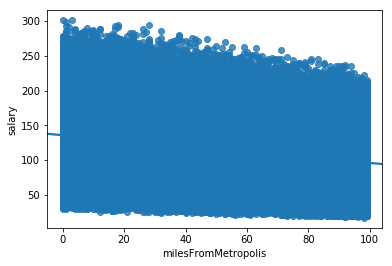

In [0]:
sns.regplot(x='milesFromMetropolis',y='salary',data=train_target_joined)

* **There is a weak negative linear relationship between miles from metropolis and salary**

### Categorical Variables

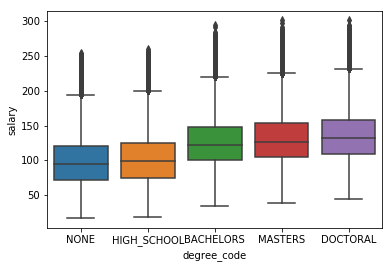

In [0]:
ax = sns.boxplot(x='degree_code',y='salary',data=train_target_joined)
ax.set_xticklabels(degree_dict.keys());

* **There is a positive relationship between the ordinal levels of degree and salary.**

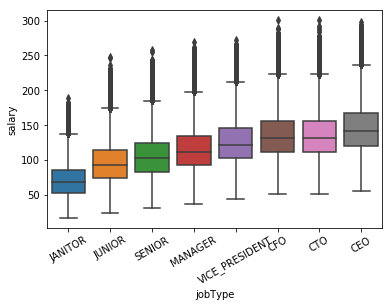

In [0]:
sorted_job_types = train_target_joined.groupby('jobType')['salary'].mean().sort_values()
ax = sns.boxplot(x='jobType',y='salary',data=train_target_joined,order=sorted_job_types.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

* **There is a positive relationship between more senior/executive job types and salary.**

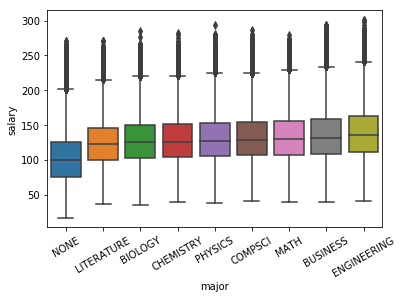

In [0]:
sorted_majors = train_target_joined.groupby('major')['salary'].mean().sort_values()
ax = sns.boxplot(x='major',y='salary',data=train_target_joined,order=sorted_majors.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

* **Having no major has a distribution of salaries that is noticeably lower than jobs with an explicit major**

In [0]:
sorted_industries = train_target_joined.groupby('industry')['salary'].mean().sort_values()
sorted_industries

industry
EDUCATION     99.448386
SERVICE      104.446820
AUTO         109.435222
HEALTH       115.735540
WEB          121.645362
FINANCE      130.747659
OIL          130.953863
Name: salary, dtype: float64

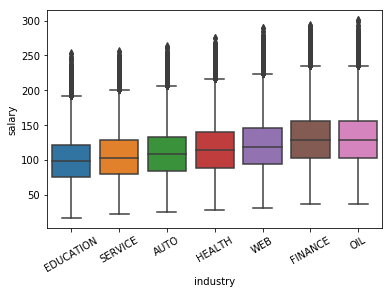

In [0]:
ax = sns.boxplot(x='industry',y='salary',data=train_target_joined,order=sorted_industries.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

* **Finance and oil industries have noticeably higher salary distributions, as would be expected.**

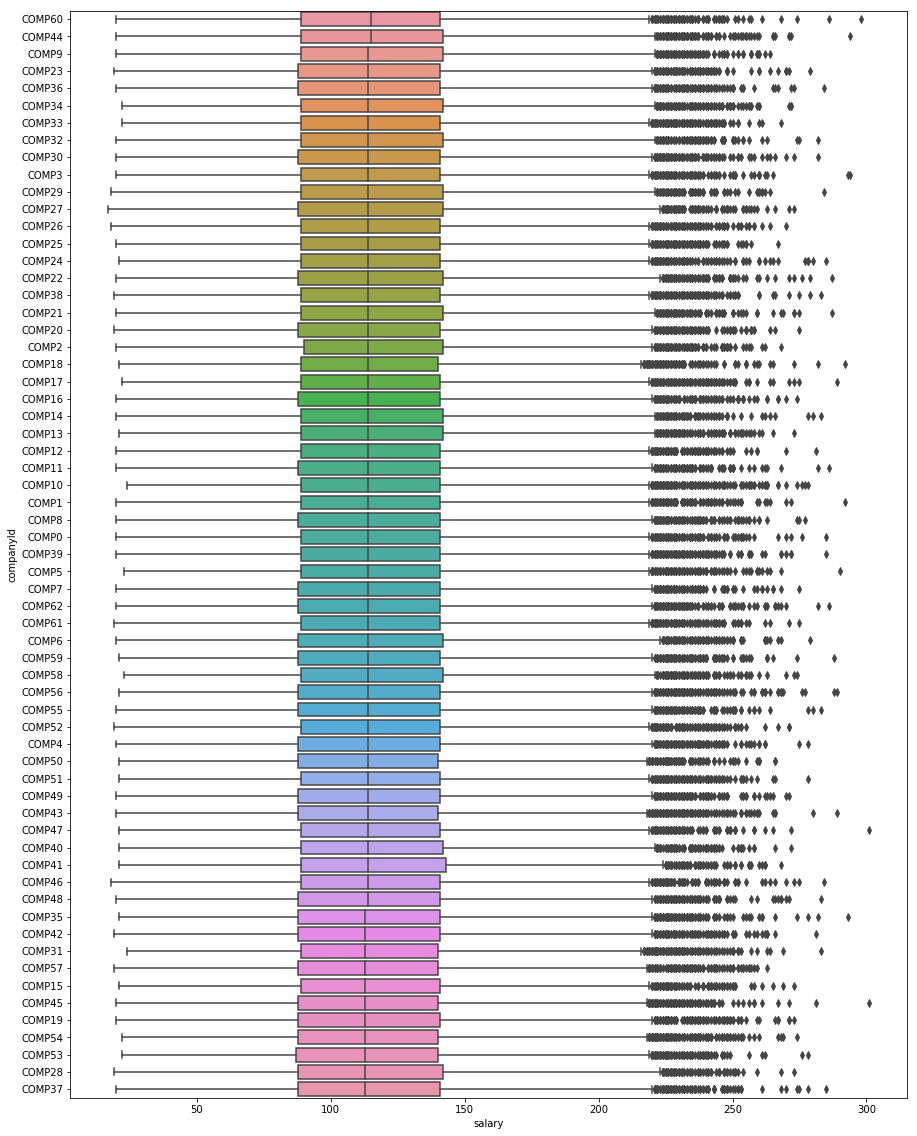

In [0]:
fig = plt.pyplot.figure(figsize=(15, 20))
ax = fig.add_subplot(111)
my_order = train_target_joined.groupby(by=["companyId"])["salary"].median().sort_values().iloc[::-1].index

ax = sns.boxplot(ax=ax,x='salary',y='companyId',data=train_target_joined,orient="h",order=my_order)


* **This shows there is not much variance between companies on salary. Also see ANOVA results below.**

### ANOVA

In [0]:
#f_val, p_val = stats.f_oneway(grouped_test2.get_group('fwd')['price'], grouped_test2.get_group('rwd')['price'], grouped_test2.get_group('4wd')['price'])  
grouped = train_target_joined.groupby('degree');
calcANOVA(grouped,'salary')

ANOVA results for  BACHELORS  and  DOCTORAL : F= 7043.02407297 , P = 0.0
ANOVA results for  BACHELORS  and  HIGH_SCHOOL : F= 43909.1321428 , P = 0.0
ANOVA results for  BACHELORS  and  MASTERS : F= 1803.59393016 , P = 0.0
ANOVA results for  BACHELORS  and  NONE : F= 61336.513161 , P = 0.0
ANOVA results for  DOCTORAL  and  BACHELORS : F= 7043.02407297 , P = 0.0
ANOVA results for  DOCTORAL  and  HIGH_SCHOOL : F= 87752.3916893 , P = 0.0
ANOVA results for  DOCTORAL  and  MASTERS : F= 1719.62081936 , P = 0.0
ANOVA results for  DOCTORAL  and  NONE : F= 112649.176391 , P = 0.0
ANOVA results for  HIGH_SCHOOL  and  BACHELORS : F= 43909.1321428 , P = 0.0
ANOVA results for  HIGH_SCHOOL  and  DOCTORAL : F= 87752.3916893 , P = 0.0
ANOVA results for  HIGH_SCHOOL  and  MASTERS : F= 64199.9318937 , P = 0.0
ANOVA results for  HIGH_SCHOOL  and  NONE : F= 1316.30078899 , P = 8.08611741335e-288
ANOVA results for  MASTERS  and  BACHELORS : F= 1803.59393016 , P = 0.0
ANOVA results for  MASTERS  and  DOCTORAL

In [0]:
grouped = train_target_joined.groupby('jobType');
grouped = calcANOVA(grouped,'salary')

ANOVA results for  CEO  and  CFO : F= 5307.12241423 , P = 0.0
ANOVA results for  CEO  and  CTO : F= 5294.4617257 , P = 0.0
ANOVA results for  CEO  and  JANITOR : F= 386784.963955 , P = 0.0
ANOVA results for  CEO  and  JUNIOR : F= 152621.408424 , P = 0.0
ANOVA results for  CEO  and  MANAGER : F= 52461.3015942 , P = 0.0
ANOVA results for  CEO  and  SENIOR : F= 95195.3887359 , P = 0.0
ANOVA results for  CEO  and  VICE_PRESIDENT : F= 22537.9400176 , P = 0.0
ANOVA results for  CFO  and  CEO : F= 5307.12241423 , P = 0.0
ANOVA results for  CFO  and  CTO : F= 0.0288977080762 , P = 0.86501557597
ANOVA results for  CFO  and  JANITOR : F= 306527.727781 , P = 0.0
ANOVA results for  CFO  and  JUNIOR : F= 102846.367612 , P = 0.0
ANOVA results for  CFO  and  MANAGER : F= 24633.4604323 , P = 0.0
ANOVA results for  CFO  and  SENIOR : F= 56290.9927084 , P = 0.0
ANOVA results for  CFO  and  VICE_PRESIDENT : F= 6008.64689456 , P = 0.0
ANOVA results for  CTO  and  CEO : F= 5294.4617257 , P = 0.0
ANOVA resu

In [0]:
grouped = train_target_joined.groupby('major');
grouped = calcANOVA(grouped,'salary')

ANOVA results for  BIOLOGY  and  BUSINESS : F= 1347.77586226 , P = 2.22750954303e-293
ANOVA results for  BIOLOGY  and  CHEMISTRY : F= 31.377160062 , P = 2.1294014364e-08
ANOVA results for  BIOLOGY  and  COMPSCI : F= 413.748960346 , P = 8.08466897679e-92
ANOVA results for  BIOLOGY  and  ENGINEERING : F= 2418.54331942 , P = 0.0
ANOVA results for  BIOLOGY  and  LITERATURE : F= 308.143516878 , P = 6.79414186958e-69
ANOVA results for  BIOLOGY  and  MATH : F= 681.630203906 , P = 8.02053112021e-150
ANOVA results for  BIOLOGY  and  NONE : F= 26071.9976206 , P = 0.0
ANOVA results for  BIOLOGY  and  PHYSICS : F= 142.78158626 , P = 6.85785218685e-33
ANOVA results for  BUSINESS  and  BIOLOGY : F= 1347.77586226 , P = 2.22750954303e-293
ANOVA results for  BUSINESS  and  CHEMISTRY : F= 983.201790394 , P = 6.25962114585e-215
ANOVA results for  BUSINESS  and  COMPSCI : F= 289.384645106 , P = 8.1063428274e-65
ANOVA results for  BUSINESS  and  ENGINEERING : F= 161.496330376 , P = 5.63875862451e-37
ANOVA 

In [0]:
grouped = train_target_joined.groupby('industry');
grouped = calcANOVA(grouped,'salary')

ANOVA results for  AUTO  and  EDUCATION : F= 5620.65664161 , P = 0.0
ANOVA results for  AUTO  and  FINANCE : F= 23424.8897004 , P = 0.0
ANOVA results for  AUTO  and  HEALTH : F= 2130.36955478 , P = 0.0
ANOVA results for  AUTO  and  OIL : F= 23735.4948813 , P = 0.0
ANOVA results for  AUTO  and  SERVICE : F= 1383.42640699 , P = 4.46951884876e-302
ANOVA results for  AUTO  and  WEB : F= 7730.18424997 , P = 0.0
ANOVA results for  EDUCATION  and  AUTO : F= 5620.65664161 , P = 0.0
ANOVA results for  EDUCATION  and  FINANCE : F= 51805.1336483 , P = 0.0
ANOVA results for  EDUCATION  and  HEALTH : F= 14614.604956 , P = 0.0
ANOVA results for  EDUCATION  and  OIL : F= 52164.145671 , P = 0.0
ANOVA results for  EDUCATION  and  SERVICE : F= 1427.26625201 , P = 1.48174870093e-311
ANOVA results for  EDUCATION  and  WEB : F= 26197.7244575 , P = 0.0
ANOVA results for  FINANCE  and  AUTO : F= 23424.8897004 , P = 0.0
ANOVA results for  FINANCE  and  EDUCATION : F= 51805.1336483 , P = 0.0
ANOVA results for 

In [0]:
grouped = train_target_joined.groupby('companyId');
grouped = calcANOVA(grouped,'salary')

ANOVA results for  COMP0  and  COMP1 : F= 0.0383332984552 , P = 0.844776651812
ANOVA results for  COMP0  and  COMP10 : F= 0.0166418766639 , P = 0.897355781886
ANOVA results for  COMP0  and  COMP11 : F= 0.118044527059 , P = 0.7311674019
ANOVA results for  COMP0  and  COMP12 : F= 0.07945291393 , P = 0.778042032938
ANOVA results for  COMP0  and  COMP13 : F= 1.88438562574 , P = 0.169846264474
ANOVA results for  COMP0  and  COMP14 : F= 0.610231799974 , P = 0.434706404051
ANOVA results for  COMP0  and  COMP15 : F= 0.0719681022683 , P = 0.788494240429
ANOVA results for  COMP0  and  COMP16 : F= 0.8182736037 , P = 0.365692337289
ANOVA results for  COMP0  and  COMP17 : F= 0.642892603573 , P = 0.422671352239
ANOVA results for  COMP0  and  COMP18 : F= 0.715079381609 , P = 0.397769118495
ANOVA results for  COMP0  and  COMP19 : F= 0.227037773778 , P = 0.633732319124
ANOVA results for  COMP0  and  COMP2 : F= 3.32384463673 , P = 0.0682915069178
ANOVA results for  COMP0  and  COMP20 : F= 0.004576916445

ANOVA results for  COMP10  and  COMP4 : F= 0.234552174275 , P = 0.628172144484
ANOVA results for  COMP10  and  COMP40 : F= 3.16165763107 , P = 0.0753961190447
ANOVA results for  COMP10  and  COMP41 : F= 1.29115930941 , P = 0.255842986692
ANOVA results for  COMP10  and  COMP42 : F= 1.51883991858 , P = 0.217804229866
ANOVA results for  COMP10  and  COMP43 : F= 0.255589657901 , P = 0.613169937149
ANOVA results for  COMP10  and  COMP44 : F= 2.31688099096 , P = 0.127986315801
ANOVA results for  COMP10  and  COMP45 : F= 0.725576464205 , P = 0.394327220555
ANOVA results for  COMP10  and  COMP46 : F= 0.00305694337201 , P = 0.955908068772
ANOVA results for  COMP10  and  COMP47 : F= 0.0266378308649 , P = 0.870353345058
ANOVA results for  COMP10  and  COMP48 : F= 0.272326536576 , P = 0.601778994987
ANOVA results for  COMP10  and  COMP49 : F= 0.327395144698 , P = 0.567201021268
ANOVA results for  COMP10  and  COMP5 : F= 0.0684367712713 , P = 0.79362828462
ANOVA results for  COMP10  and  COMP50 : F

ANOVA results for  COMP12  and  COMP58 : F= 0.684316875702 , P = 0.408110393882
ANOVA results for  COMP12  and  COMP59 : F= 0.248540565713 , P = 0.618108032824
ANOVA results for  COMP12  and  COMP6 : F= 0.0191670121495 , P = 0.889889632991
ANOVA results for  COMP12  and  COMP60 : F= 0.119877569308 , P = 0.729169620043
ANOVA results for  COMP12  and  COMP61 : F= 0.285426139459 , P = 0.593170346207
ANOVA results for  COMP12  and  COMP62 : F= 0.195622814255 , P = 0.658280442869
ANOVA results for  COMP12  and  COMP7 : F= 0.207251145322 , P = 0.648933645528
ANOVA results for  COMP12  and  COMP8 : F= 0.0491216261082 , P = 0.824600259648
ANOVA results for  COMP12  and  COMP9 : F= 0.71057360361 , P = 0.399259801433
ANOVA results for  COMP13  and  COMP0 : F= 1.88438562574 , P = 0.169846264474
ANOVA results for  COMP13  and  COMP1 : F= 1.40025792847 , P = 0.236689243072
ANOVA results for  COMP13  and  COMP10 : F= 1.5520321182 , P = 0.212844856011
ANOVA results for  COMP13  and  COMP11 : F= 1.067

ANOVA results for  COMP15  and  COMP22 : F= 0.688708039156 , P = 0.406610400981
ANOVA results for  COMP15  and  COMP23 : F= 0.917774443928 , P = 0.338067289234
ANOVA results for  COMP15  and  COMP24 : F= 0.576963371569 , P = 0.447510693
ANOVA results for  COMP15  and  COMP25 : F= 0.827606012803 , P = 0.362972578513
ANOVA results for  COMP15  and  COMP26 : F= 0.0674606218734 , P = 0.795072330112
ANOVA results for  COMP15  and  COMP27 : F= 0.0597174686434 , P = 0.806944634234
ANOVA results for  COMP15  and  COMP28 : F= 0.0487909874988 , P = 0.82518198256
ANOVA results for  COMP15  and  COMP29 : F= 1.55267357763 , P = 0.212750404314
ANOVA results for  COMP15  and  COMP3 : F= 0.667596091324 , P = 0.413897073256
ANOVA results for  COMP15  and  COMP30 : F= 0.186998303225 , P = 0.665429654367
ANOVA results for  COMP15  and  COMP31 : F= 0.269538588124 , P = 0.60364508891
ANOVA results for  COMP15  and  COMP32 : F= 0.0865474201807 , P = 0.768615074504
ANOVA results for  COMP15  and  COMP33 : F=

ANOVA results for  COMP17  and  COMP57 : F= 4.41182969803 , P = 0.0356985077972
ANOVA results for  COMP17  and  COMP58 : F= 0.0883868439776 , P = 0.766240003943
ANOVA results for  COMP17  and  COMP59 : F= 1.03881808031 , P = 0.308104273594
ANOVA results for  COMP17  and  COMP6 : F= 0.147049829606 , P = 0.701373324644
ANOVA results for  COMP17  and  COMP60 : F= 0.0331978318972 , P = 0.855424808924
ANOVA results for  COMP17  and  COMP61 : F= 3.70766680196e-05 , P = 0.995141700455
ANOVA results for  COMP17  and  COMP62 : F= 0.00669833007484 , P = 0.934771819578
ANOVA results for  COMP17  and  COMP7 : F= 0.950664155485 , P = 0.329557791953
ANOVA results for  COMP17  and  COMP8 : F= 0.548784881405 , P = 0.458820164581
ANOVA results for  COMP17  and  COMP9 : F= 0.0981100492881 , P = 0.754111606502
ANOVA results for  COMP18  and  COMP0 : F= 0.715079381609 , P = 0.397769118495
ANOVA results for  COMP18  and  COMP1 : F= 1.09568192976 , P = 0.295223659218
ANOVA results for  COMP18  and  COMP10 :

ANOVA results for  COMP2  and  COMP38 : F= 1.64352621834 , P = 0.199851790508
ANOVA results for  COMP2  and  COMP39 : F= 2.43009646456 , P = 0.119035515025
ANOVA results for  COMP2  and  COMP4 : F= 1.46478647668 , P = 0.226179140229
ANOVA results for  COMP2  and  COMP40 : F= 0.00517520642733 , P = 0.942650981059
ANOVA results for  COMP2  and  COMP41 : F= 0.310664430262 , P = 0.577276711045
ANOVA results for  COMP2  and  COMP42 : F= 8.56862487932 , P = 0.00342249244813
ANOVA results for  COMP2  and  COMP43 : F= 4.84968160374 , P = 0.0276584334878
ANOVA results for  COMP2  and  COMP44 : F= 0.0323911401861 , P = 0.857173042889
ANOVA results for  COMP2  and  COMP45 : F= 6.48449585421 , P = 0.0108866578721
ANOVA results for  COMP2  and  COMP46 : F= 2.72533268539 , P = 0.0987774750689
ANOVA results for  COMP2  and  COMP47 : F= 3.45518317612 , P = 0.0630630867432
ANOVA results for  COMP2  and  COMP48 : F= 4.94462618422 , P = 0.0261789466138
ANOVA results for  COMP2  and  COMP49 : F= 1.2536059

ANOVA results for  COMP22  and  COMP16 : F= 0.119258256276 , P = 0.729842659064
ANOVA results for  COMP22  and  COMP17 : F= 0.060704039958 , P = 0.805388216578
ANOVA results for  COMP22  and  COMP18 : F= 1.98300782431 , P = 0.159083654028
ANOVA results for  COMP22  and  COMP19 : F= 1.07673776649 , P = 0.29943636219
ANOVA results for  COMP22  and  COMP2 : F= 1.59614504473 , P = 0.206459707573
ANOVA results for  COMP22  and  COMP20 : F= 0.395042039654 , P = 0.529665439007
ANOVA results for  COMP22  and  COMP21 : F= 0.579845988314 , P = 0.446378332241
ANOVA results for  COMP22  and  COMP23 : F= 0.0152423929041 , P = 0.901743558661
ANOVA results for  COMP22  and  COMP24 : F= 0.00511260665166 , P = 0.942998290265
ANOVA results for  COMP22  and  COMP25 : F= 0.00539278305556 , P = 0.941459973951
ANOVA results for  COMP22  and  COMP26 : F= 0.324179085508 , P = 0.569110965268
ANOVA results for  COMP22  and  COMP27 : F= 0.337298678826 , P = 0.561396772862
ANOVA results for  COMP22  and  COMP28 :

ANOVA results for  COMP24  and  COMP52 : F= 0.0120392293569 , P = 0.912629421909
ANOVA results for  COMP24  and  COMP53 : F= 3.67356897307 , P = 0.0552906977487
ANOVA results for  COMP24  and  COMP54 : F= 1.84346829246 , P = 0.17455461792
ANOVA results for  COMP24  and  COMP55 : F= 1.60562491283 , P = 0.205117236059
ANOVA results for  COMP24  and  COMP56 : F= 0.00908034023921 , P = 0.924084434894
ANOVA results for  COMP24  and  COMP57 : F= 3.23531580663 , P = 0.0720759879094
ANOVA results for  COMP24  and  COMP58 : F= 0.385386773579 , P = 0.53473878308
ANOVA results for  COMP24  and  COMP59 : F= 0.499181734421 , P = 0.479865042879
ANOVA results for  COMP24  and  COMP6 : F= 0.00456002482066 , P = 0.946161833619
ANOVA results for  COMP24  and  COMP60 : F= 0.01917835788 , P = 0.889857255885
ANOVA results for  COMP24  and  COMP61 : F= 0.107164605018 , P = 0.743397740649
ANOVA results for  COMP24  and  COMP62 : F= 0.0559974151577 , P = 0.812939372766
ANOVA results for  COMP24  and  COMP7 : 

ANOVA results for  COMP27  and  COMP31 : F= 0.576625660676 , P = 0.447643679537
ANOVA results for  COMP27  and  COMP32 : F= 0.00228860860049 , P = 0.961844533517
ANOVA results for  COMP27  and  COMP33 : F= 0.022773366812 , P = 0.880048881728
ANOVA results for  COMP27  and  COMP34 : F= 1.04865359164 , P = 0.305825224651
ANOVA results for  COMP27  and  COMP35 : F= 0.168856111778 , P = 0.681133186001
ANOVA results for  COMP27  and  COMP36 : F= 0.100601817199 , P = 0.751110713074
ANOVA results for  COMP27  and  COMP37 : F= 1.94625357863 , P = 0.163000917193
ANOVA results for  COMP27  and  COMP38 : F= 0.315542336028 , P = 0.574302919122
ANOVA results for  COMP27  and  COMP39 : F= 0.0955016063021 , P = 0.757298178476
ANOVA results for  COMP27  and  COMP4 : F= 0.401565588702 , P = 0.526286401
ANOVA results for  COMP27  and  COMP40 : F= 3.69697656981 , P = 0.0545200869885
ANOVA results for  COMP27  and  COMP41 : F= 1.64528111736 , P = 0.199611814486
ANOVA results for  COMP27  and  COMP42 : F= 

ANOVA results for  COMP3  and  COMP13 : F= 0.702164194974 , P = 0.40206370963
ANOVA results for  COMP3  and  COMP14 : F= 0.0581588966325 , P = 0.809431452937
ANOVA results for  COMP3  and  COMP15 : F= 0.667596091324 , P = 0.413897073256
ANOVA results for  COMP3  and  COMP16 : F= 0.13482741312 , P = 0.713480840615
ANOVA results for  COMP3  and  COMP17 : F= 0.0714638671136 , P = 0.78921893208
ANOVA results for  COMP3  and  COMP18 : F= 1.95952736004 , P = 0.161573574982
ANOVA results for  COMP3  and  COMP19 : F= 1.05359629949 , P = 0.304688040935
ANOVA results for  COMP3  and  COMP2 : F= 1.67032179624 , P = 0.196224868394
ANOVA results for  COMP3  and  COMP20 : F= 0.377192527739 , P = 0.539113965835
ANOVA results for  COMP3  and  COMP21 : F= 0.618734847212 , P = 0.43152364309
ANOVA results for  COMP3  and  COMP22 : F= 0.000367662891289 , P = 0.984701989733
ANOVA results for  COMP3  and  COMP23 : F= 0.0206460015246 , P = 0.885748412835
ANOVA results for  COMP3  and  COMP24 : F= 0.002792867

ANOVA results for  COMP31  and  COMP50 : F= 0.331357702615 , P = 0.564864821322
ANOVA results for  COMP31  and  COMP51 : F= 2.37595990687 , P = 0.123225802037
ANOVA results for  COMP31  and  COMP52 : F= 1.91713115293 , P = 0.166183075606
ANOVA results for  COMP31  and  COMP53 : F= 0.414505260017 , P = 0.51969630822
ANOVA results for  COMP31  and  COMP54 : F= 0.00565317648809 , P = 0.940065917325
ANOVA results for  COMP31  and  COMP55 : F= 1.13576323136e-05 , P = 0.997311068723
ANOVA results for  COMP31  and  COMP56 : F= 1.38006147384 , P = 0.240099491454
ANOVA results for  COMP31  and  COMP57 : F= 0.276670264604 , P = 0.598895711039
ANOVA results for  COMP31  and  COMP58 : F= 3.6031437618 , P = 0.0576794863263
ANOVA results for  COMP31  and  COMP59 : F= 0.327670722614 , P = 0.56703792486
ANOVA results for  COMP31  and  COMP6 : F= 1.44681739056 , P = 0.229048331065
ANOVA results for  COMP31  and  COMP60 : F= 2.01956484535 , P = 0.155293519026
ANOVA results for  COMP31  and  COMP61 : F= 

ANOVA results for  COMP34  and  COMP31 : F= 3.20268009989 , P = 0.0735272855395
ANOVA results for  COMP34  and  COMP32 : F= 0.966273106074 , P = 0.3256189044
ANOVA results for  COMP34  and  COMP33 : F= 0.764632403357 , P = 0.381889344438
ANOVA results for  COMP34  and  COMP35 : F= 2.08278341547 , P = 0.148978130717
ANOVA results for  COMP34  and  COMP36 : F= 0.505159070556 , P = 0.477247229555
ANOVA results for  COMP34  and  COMP37 : F= 5.88677786897 , P = 0.0152605256106
ANOVA results for  COMP34  and  COMP38 : F= 0.215149946858 , P = 0.642763720482
ANOVA results for  COMP34  and  COMP39 : F= 0.532796903308 , P = 0.465438694218
ANOVA results for  COMP34  and  COMP4 : F= 0.153707925873 , P = 0.695019453024
ANOVA results for  COMP34  and  COMP40 : F= 0.797423967868 , P = 0.37187143303
ANOVA results for  COMP34  and  COMP41 : F= 0.0670865468218 , P = 0.795628662211
ANOVA results for  COMP34  and  COMP42 : F= 4.43176572355 , P = 0.0352838309498
ANOVA results for  COMP34  and  COMP43 : F= 

ANOVA results for  COMP36  and  COMP9 : F= 0.690145603521 , P = 0.406121081962
ANOVA results for  COMP37  and  COMP0 : F= 2.02225065367 , P = 0.155019120351
ANOVA results for  COMP37  and  COMP1 : F= 2.64129320169 , P = 0.104128694148
ANOVA results for  COMP37  and  COMP10 : F= 2.41388924298 , P = 0.120273194489
ANOVA results for  COMP37  and  COMP11 : F= 3.13621560858 , P = 0.0765808690543
ANOVA results for  COMP37  and  COMP12 : F= 2.90940053223 , P = 0.0880744033099
ANOVA results for  COMP37  and  COMP13 : F= 7.84125988473 , P = 0.00510977433883
ANOVA results for  COMP37  and  COMP14 : F= 4.88016325649 , P = 0.0271741487504
ANOVA results for  COMP37  and  COMP15 : F= 1.34418038749 , P = 0.246306795984
ANOVA results for  COMP37  and  COMP16 : F= 5.42143255114 , P = 0.0198972918048
ANOVA results for  COMP37  and  COMP17 : F= 4.90996831591 , P = 0.0267092250672
ANOVA results for  COMP37  and  COMP18 : F= 0.340387116207 , P = 0.559609986158
ANOVA results for  COMP37  and  COMP19 : F= 0.

ANOVA results for  COMP39  and  COMP4 : F= 0.111139584565 , P = 0.738852623251
ANOVA results for  COMP39  and  COMP40 : F= 2.68964850789 , P = 0.101011860654
ANOVA results for  COMP39  and  COMP41 : F= 0.984957946872 , P = 0.32098531915
ANOVA results for  COMP39  and  COMP42 : F= 1.96503911081 , P = 0.160985077251
ANOVA results for  COMP39  and  COMP43 : F= 0.445297930913 , P = 0.504581181635
ANOVA results for  COMP39  and  COMP44 : F= 1.90896970609 , P = 0.167087337662
ANOVA results for  COMP39  and  COMP45 : F= 1.03447783006 , P = 0.30911694943
ANOVA results for  COMP39  and  COMP46 : F= 0.0102622280727 , P = 0.919310839585
ANOVA results for  COMP39  and  COMP47 : F= 0.103157423808 , P = 0.748075105218
ANOVA results for  COMP39  and  COMP48 : F= 0.468192521966 , P = 0.493824806684
ANOVA results for  COMP39  and  COMP49 : F= 0.17847226468 , P = 0.672692293754
ANOVA results for  COMP39  and  COMP5 : F= 0.17717114354 , P = 0.67381849915
ANOVA results for  COMP39  and  COMP50 : F= 0.2484

ANOVA results for  COMP40  and  COMP57 : F= 10.3677497889 , P = 0.00128365160406
ANOVA results for  COMP40  and  COMP58 : F= 0.631506968678 , P = 0.426808985957
ANOVA results for  COMP40  and  COMP59 : F= 4.53599319912 , P = 0.0331967836662
ANOVA results for  COMP40  and  COMP6 : F= 2.18549394864 , P = 0.139326253945
ANOVA results for  COMP40  and  COMP60 : F= 1.65078659864 , P = 0.198861261939
ANOVA results for  COMP40  and  COMP61 : F= 1.18926905308 , P = 0.275485302602
ANOVA results for  COMP40  and  COMP62 : F= 1.37518606852 , P = 0.24093158364
ANOVA results for  COMP40  and  COMP7 : F= 4.33713917175 , P = 0.037297509204
ANOVA results for  COMP40  and  COMP8 : F= 3.38677943152 , P = 0.0657305605212
ANOVA results for  COMP40  and  COMP9 : F= 0.605108819235 , P = 0.436641144681
ANOVA results for  COMP41  and  COMP0 : F= 1.59525375053 , P = 0.206586464448
ANOVA results for  COMP41  and  COMP1 : F= 1.15273209295 , P = 0.282986134919
ANOVA results for  COMP41  and  COMP10 : F= 1.2911593

ANOVA results for  COMP43  and  COMP35 : F= 0.00343627749047 , P = 0.953255328483
ANOVA results for  COMP43  and  COMP36 : F= 0.45118647588 , P = 0.501776926574
ANOVA results for  COMP43  and  COMP37 : F= 1.09865752797 , P = 0.294568861341
ANOVA results for  COMP43  and  COMP38 : F= 0.840336149394 , P = 0.359307607523
ANOVA results for  COMP43  and  COMP39 : F= 0.445297930913 , P = 0.504581181635
ANOVA results for  COMP43  and  COMP4 : F= 0.978301852534 , P = 0.322625920166
ANOVA results for  COMP43  and  COMP40 : F= 5.22626916493 , P = 0.022254717374
ANOVA results for  COMP43  and  COMP41 : F= 2.69184881499 , P = 0.100872608596
ANOVA results for  COMP43  and  COMP42 : F= 0.528929998731 , P = 0.467062395811
ANOVA results for  COMP43  and  COMP44 : F= 4.11672764446 , P = 0.0424694084196
ANOVA results for  COMP43  and  COMP45 : F= 0.120271956308 , P = 0.728742012561
ANOVA results for  COMP43  and  COMP46 : F= 0.317589404905 , P = 0.573063897164
ANOVA results for  COMP43  and  COMP47 : F=

ANOVA results for  COMP46  and  COMP13 : F= 1.43313442644 , P = 0.231262468992
ANOVA results for  COMP46  and  COMP14 : F= 0.36143379896 , P = 0.54771529208
ANOVA results for  COMP46  and  COMP15 : F= 0.207787938807 , P = 0.648509853325
ANOVA results for  COMP46  and  COMP16 : F= 0.527123539187 , P = 0.467824052258
ANOVA results for  COMP46  and  COMP17 : F= 0.389133433656 , P = 0.532759749232
ANOVA results for  COMP46  and  COMP18 : F= 1.07653173759 , P = 0.2994825867
ANOVA results for  COMP46  and  COMP19 : F= 0.442709807642 , P = 0.5058222452
ANOVA results for  COMP46  and  COMP2 : F= 2.72533268539 , P = 0.0987774750689
ANOVA results for  COMP46  and  COMP20 : F= 0.0642947713068 , P = 0.79983394157
ANOVA results for  COMP46  and  COMP21 : F= 1.31391382787 , P = 0.251695850665
ANOVA results for  COMP46  and  COMP22 : F= 0.143076693758 , P = 0.705243838815
ANOVA results for  COMP46  and  COMP23 : F= 0.254486334134 , P = 0.613937164142
ANOVA results for  COMP46  and  COMP24 : F= 0.0942

ANOVA results for  COMP48  and  COMP5 : F= 0.0676100910962 , P = 0.794850492416
ANOVA results for  COMP48  and  COMP50 : F= 0.033022740291 , P = 0.855802374214
ANOVA results for  COMP48  and  COMP51 : F= 1.31944321083 , P = 0.250700605424
ANOVA results for  COMP48  and  COMP52 : F= 0.985549594433 , P = 0.320840116421
ANOVA results for  COMP48  and  COMP53 : F= 1.08299726873 , P = 0.298035948767
ANOVA results for  COMP48  and  COMP54 : F= 0.224179308419 , P = 0.635877020457
ANOVA results for  COMP48  and  COMP55 : F= 0.15284805235 , P = 0.695831008605
ANOVA results for  COMP48  and  COMP56 : F= 0.614462252106 , P = 0.4331184421
ANOVA results for  COMP48  and  COMP57 : F= 0.850950161563 , P = 0.356290731789
ANOVA results for  COMP48  and  COMP58 : F= 2.27112358657 , P = 0.131814219924
ANOVA results for  COMP48  and  COMP59 : F= 0.0313533247656 , P = 0.859455547512
ANOVA results for  COMP48  and  COMP6 : F= 0.659200377031 , P = 0.416848466286
ANOVA results for  COMP48  and  COMP60 : F= 1.

ANOVA results for  COMP50  and  COMP31 : F= 0.331357702615 , P = 0.564864821322
ANOVA results for  COMP50  and  COMP32 : F= 0.0551165734457 , P = 0.814389394897
ANOVA results for  COMP50  and  COMP33 : F= 0.113728691967 , P = 0.735940602021
ANOVA results for  COMP50  and  COMP34 : F= 1.47248542695 , P = 0.224963028869
ANOVA results for  COMP50  and  COMP35 : F= 0.0508409238981 , P = 0.821607855448
ANOVA results for  COMP50  and  COMP36 : F= 0.254629833544 , P = 0.613837281953
ANOVA results for  COMP50  and  COMP37 : F= 1.47283701143 , P = 0.224907653899
ANOVA results for  COMP50  and  COMP38 : F= 0.562007353498 , P = 0.453458157674
ANOVA results for  COMP50  and  COMP39 : F= 0.248439164086 , P = 0.618179688205
ANOVA results for  COMP50  and  COMP4 : F= 0.675558857919 , P = 0.411126403699
ANOVA results for  COMP50  and  COMP40 : F= 4.48018458151 , P = 0.034297763945
ANOVA results for  COMP50  and  COMP41 : F= 2.16976827179 , P = 0.140757386367
ANOVA results for  COMP50  and  COMP42 : F=

ANOVA results for  COMP53  and  COMP11 : F= 3.14567586271 , P = 0.0761380704122
ANOVA results for  COMP53  and  COMP12 : F= 2.91891781314 , P = 0.0875563938752
ANOVA results for  COMP53  and  COMP13 : F= 7.84435100108 , P = 0.00510105914367
ANOVA results for  COMP53  and  COMP14 : F= 4.88802262424 , P = 0.0270507581869
ANOVA results for  COMP53  and  COMP15 : F= 1.35323620067 , P = 0.24472191884
ANOVA results for  COMP53  and  COMP16 : F= 5.42855059918 , P = 0.0198163872463
ANOVA results for  COMP53  and  COMP17 : F= 4.91736979293 , P = 0.0265950762123
ANOVA results for  COMP53  and  COMP18 : F= 0.346316326048 , P = 0.55621000107
ANOVA results for  COMP53  and  COMP19 : F= 0.909911313542 , P = 0.340145217129
ANOVA results for  COMP53  and  COMP2 : F= 10.5582476275 , P = 0.00115792385295
ANOVA results for  COMP53  and  COMP20 : F= 1.85486803874 , P = 0.173227955285
ANOVA results for  COMP53  and  COMP21 : F= 7.57477166587 , P = 0.00592245000781
ANOVA results for  COMP53  and  COMP22 : F

ANOVA results for  COMP55  and  COMP41 : F= 4.15239679966 , P = 0.0415839400922
ANOVA results for  COMP55  and  COMP42 : F= 0.102575318515 , P = 0.748762879269
ANOVA results for  COMP55  and  COMP43 : F= 0.163596880807 , P = 0.685869043544
ANOVA results for  COMP55  and  COMP44 : F= 5.88767874514 , P = 0.0152527119999
ANOVA results for  COMP55  and  COMP45 : F= 0.00343294262339 , P = 0.953277995808
ANOVA results for  COMP55  and  COMP46 : F= 0.936987511158 , P = 0.333061160243
ANOVA results for  COMP55  and  COMP47 : F= 0.554672721321 , P = 0.456420228859
ANOVA results for  COMP55  and  COMP48 : F= 0.15284805235 , P = 0.695831008605
ANOVA results for  COMP55  and  COMP49 : F= 2.17577202604 , P = 0.14020912539
ANOVA results for  COMP55  and  COMP5 : F= 0.420458400931 , P = 0.51671311694
ANOVA results for  COMP55  and  COMP50 : F= 0.324769118968 , P = 0.568759633767
ANOVA results for  COMP55  and  COMP51 : F= 2.346099897 , P = 0.125606841687
ANOVA results for  COMP55  and  COMP52 : F= 1.

ANOVA results for  COMP57  and  COMP54 : F= 0.205908108457 , P = 0.649996783192
ANOVA results for  COMP57  and  COMP55 : F= 0.277892016561 , P = 0.598089928185
ANOVA results for  COMP57  and  COMP56 : F= 2.8747066174 , P = 0.0899912198094
ANOVA results for  COMP57  and  COMP58 : F= 5.85766910097 , P = 0.0155149220055
ANOVA results for  COMP57  and  COMP59 : F= 1.20628296062 , P = 0.272077865537
ANOVA results for  COMP57  and  COMP6 : F= 2.97102578527 , P = 0.0847779096147
ANOVA results for  COMP57  and  COMP60 : F= 3.78905481 , P = 0.0515976695193
ANOVA results for  COMP57  and  COMP61 : F= 4.53294198904 , P = 0.0332561577632
ANOVA results for  COMP57  and  COMP62 : F= 4.10817309516 , P = 0.0426848243874
ANOVA results for  COMP57  and  COMP7 : F= 1.29525661429 , P = 0.255090162284
ANOVA results for  COMP57  and  COMP8 : F= 1.86093440938 , P = 0.172526812493
ANOVA results for  COMP57  and  COMP9 : F= 5.92903869165 , P = 0.0148988548865
ANOVA results for  COMP58  and  COMP0 : F= 1.229804

ANOVA results for  COMP6  and  COMP16 : F= 0.233406590957 , P = 0.629012662015
ANOVA results for  COMP6  and  COMP17 : F= 0.147049829606 , P = 0.701373324644
ANOVA results for  COMP6  and  COMP18 : F= 1.6011531414 , P = 0.20574914406
ANOVA results for  COMP6  and  COMP19 : F= 0.802955364189 , P = 0.370218015029
ANOVA results for  COMP6  and  COMP2 : F= 1.95735633433 , P = 0.161806189903
ANOVA results for  COMP6  and  COMP20 : F= 0.238141834904 , P = 0.625554782737
ANOVA results for  COMP6  and  COMP21 : F= 0.807661185995 , P = 0.368819434415
ANOVA results for  COMP6  and  COMP22 : F= 0.0192135907126 , P = 0.889756772479
ANOVA results for  COMP6  and  COMP23 : F= 0.0688852879548 , P = 0.792968469328
ANOVA results for  COMP6  and  COMP24 : F= 0.00456002482066 , P = 0.946161833619
ANOVA results for  COMP6  and  COMP25 : F= 0.0453180753843 , P = 0.831421596987
ANOVA results for  COMP6  and  COMP26 : F= 0.184140728022 , P = 0.667841577567
ANOVA results for  COMP6  and  COMP27 : F= 0.1946098

ANOVA results for  COMP61  and  COMP54 : F= 2.85503699676 , P = 0.0910979471015
ANOVA results for  COMP61  and  COMP55 : F= 2.54648879342 , P = 0.110549674694
ANOVA results for  COMP61  and  COMP56 : F= 0.177562863337 , P = 0.673478945525
ANOVA results for  COMP61  and  COMP57 : F= 4.53294198904 , P = 0.0332561577632
ANOVA results for  COMP61  and  COMP58 : F= 0.0866116362506 , P = 0.76853170297
ANOVA results for  COMP61  and  COMP59 : F= 1.07362823706 , P = 0.300135206499
ANOVA results for  COMP61  and  COMP6 : F= 0.154953353556 , P = 0.6938486482
ANOVA results for  COMP61  and  COMP60 : F= 0.036226042907 , P = 0.849050669364
ANOVA results for  COMP61  and  COMP62 : F= 0.00788882974005 , P = 0.929226250513
ANOVA results for  COMP61  and  COMP7 : F= 0.983222625017 , P = 0.321412080541
ANOVA results for  COMP61  and  COMP8 : F= 0.569753111029 , P = 0.450362690841
ANOVA results for  COMP61  and  COMP9 : F= 0.0963421763812 , P = 0.756266156665
ANOVA results for  COMP62  and  COMP0 : F= 0.

ANOVA results for  COMP8  and  COMP24 : F= 0.183143020064 , P = 0.668688906035
ANOVA results for  COMP8  and  COMP25 : F= 0.330978245432 , P = 0.565087729283
ANOVA results for  COMP8  and  COMP26 : F= 0.00471313010828 , P = 0.945266872455
ANOVA results for  COMP8  and  COMP27 : F= 0.00678372619576 , P = 0.934358281259
ANOVA results for  COMP8  and  COMP28 : F= 0.0112381933563 , P = 0.915574820449
ANOVA results for  COMP8  and  COMP29 : F= 0.83014598869 , P = 0.362237314817
ANOVA results for  COMP8  and  COMP3 : F= 0.233402863725 , P = 0.629015395917
ANOVA results for  COMP8  and  COMP30 : F= 0.570929561906 , P = 0.449895387838
ANOVA results for  COMP8  and  COMP31 : F= 0.709672226219 , P = 0.399559064281
ANOVA results for  COMP8  and  COMP32 : F= 0.00122927149896 , P = 0.972031346532
ANOVA results for  COMP8  and  COMP33 : F= 0.00468829877938 , P = 0.945411018288
ANOVA results for  COMP8  and  COMP34 : F= 0.887139854851 , P = 0.346260794536
ANOVA results for  COMP8  and  COMP35 : F= 0.

* **From the ANOVA results, we see that all categorical features contain at least some levels that vary significantly, however for the company feature this is fairly rare.**

In [0]:
train_target_joined.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,JOBTYPE_CEO,JOBTYPE_CFO,JOBTYPE_CTO,...,MAJOR_BUSINESS,MAJOR_CHEMISTRY,MAJOR_COMPSCI,MAJOR_ENGINEERING,MAJOR_LITERATURE,MAJOR_MATH,MAJOR_NONE,MAJOR_PHYSICS,degree_code,salary
jobId,,,,,,,,,,,,,,,,,,,,,
JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,0,1,0,...,0,0,0,0,0,1,0,0,3,130
JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,1,0,0,...,0,0,0,0,0,0,1,0,1,101
JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,0,0,0,...,0,0,0,0,0,0,0,1,4,137
JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,0,0,0,...,0,1,0,0,0,0,0,0,4,142
JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,0,0,0,...,0,0,0,0,0,0,0,1,2,163


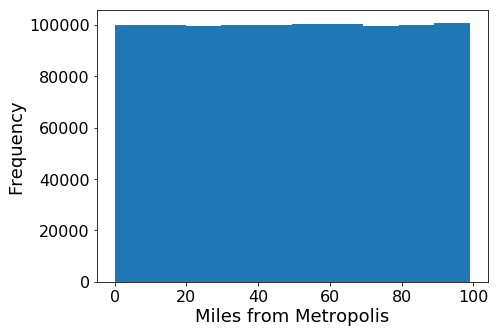

In [0]:
# Plot the histograms
train_target_joined['milesFromMetropolis'].plot.hist();
plt.pyplot.xlabel("Miles from Metropolis")

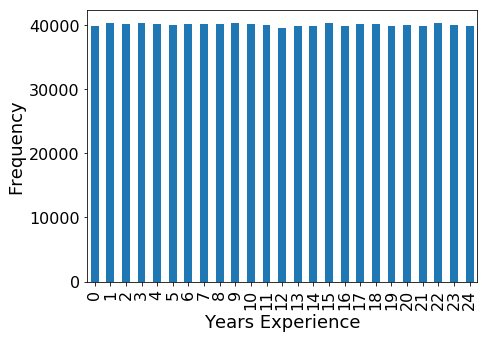

In [0]:
train_target_joined['yearsExperience'].value_counts().sort_index().plot(kind='bar');
plt.pyplot.xlabel("Years Experience");
plt.pyplot.ylabel("Frequency");

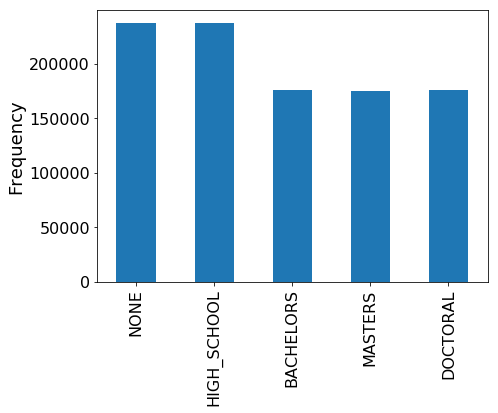

In [0]:
fig = plt.pyplot.figure(figsize=(7, 5))
ax2 = fig.add_subplot(111)
train_target_joined['degree_code'].value_counts().sort_index().plot(kind='bar')
ax2.set_xticklabels(degree_levels);
plt.pyplot.ylabel("Frequency")

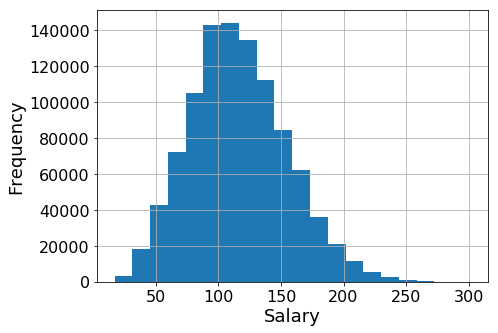

In [0]:
train_target_joined['salary'].hist(bins=20);
plt.pyplot.xlabel('Salary');
plt.pyplot.ylabel("Frequency");

In [0]:
train_target_joined['salary'].median()

114.0

In [0]:
train_target_joined['salary'].mean()

116.06239831199156

In [0]:
# Fisher-Pearson Coefficient
skew(train_target_joined['salary'])

0.3465267592829531

* **The distribution of salary is mildly right skewed**

### ---- 5 Establish a baseline ----

In [0]:
bp = baseline_predictor()

# CV = 5
yhat = cross_val_predict(bp,train_features,train_salaries,cv=5,fit_params={'index_name':unique_identifier,'target_name':'salary','baseline_feature':'jobType'})

mse = mean_squared_error(train_salaries['salary'],yhat)

In [0]:
print("MSE for model based on mean salary of job type: ",mse)

MSE for model based on mean salary of job type:  963.941702187


In [0]:
yhat = cross_val_predict(bp,train_features,train_salaries,cv=5,fit_params={'index_name':unique_identifier,'target_name':'salary','baseline_feature':'degree_code'})

mse = mean_squared_error(train_salaries['salary'],yhat)
print("MSE for model based on mean salary of degree: ",mse)

MSE for model based on mean salary of degree:  1257.62978357


### ---- 6 Hypothesize solution ----

* Linear regression (there were several weak linear correlations with salary)
* Polynomial regression (perhaps for job type field this will help since the relationship of the groups to salary looks a bit curved)
* Random Forest (Some of the relationships were not strongly linear and also want to know feature importance since there are many features from the dummy encoding)
* Gradient Boosting

#DEVELOP

### ---- 7 Engineer features  ----

#### Ideas:
- [x] Try a log transform of the salary (it was right skewed)
- [x] Try decoupling no major no degree - unless some did not complete degree (check) or some have a degree in no major (check) -> see below
- [x] Try binning the company feature to get statistically signficant differences between the groups
* What about companies with extremely high outliers? Companies with high paying exec's - adding the group statistics could help.

*  look at feature importance using regularization regression or RF

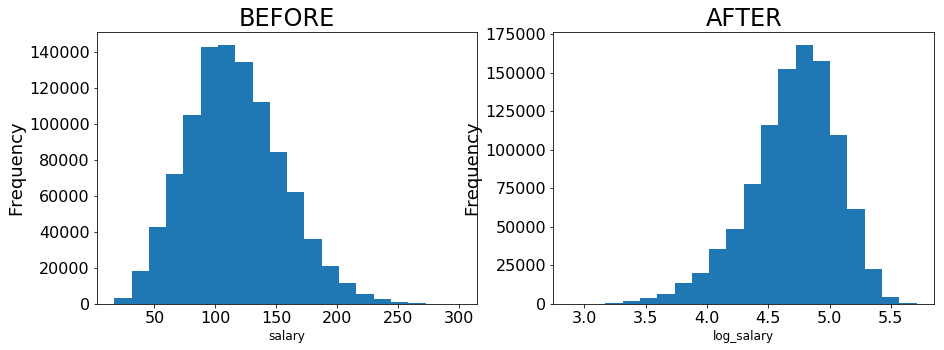

In [0]:
# Log transform of the salary
train_salaries['log_salary'] = np.log(train_salaries['salary']+1)
plot_distributions(train_salaries['salary'],train_salaries['log_salary'])

In [0]:
skew(train_salaries['salary'])

0.3465267592829531

In [0]:
skew(train_salaries['log_salary'])

-0.6509781451874523

- The log transform overcorrected the data, creating a left skewed distribution. So I will try the cube root:

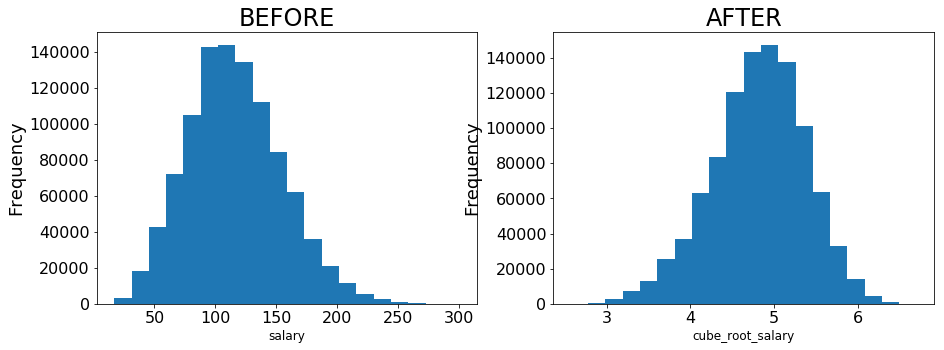

In [0]:
train_salaries['cube_root_salary'] = train_salaries['salary'].apply(lambda x: x**(1/3))
plot_distributions(train_salaries['salary'],train_salaries['cube_root_salary'])

In [0]:
skew(train_salaries['cube_root_salary'])

-0.2976687059158938

- This is better, but let's try the square root:

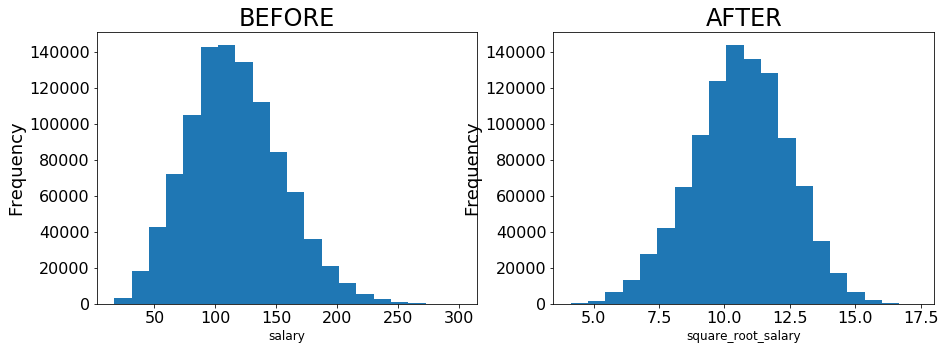

In [0]:
train_salaries['square_root_salary'] = train_salaries['salary'].apply(lambda x: x**(1/2))
plot_distributions(train_salaries['salary'],train_salaries['square_root_salary'])

- That looks much better!

In [0]:
skew(train_salaries['square_root_salary'])

-0.1280479484037874

### Look at company groups

In [0]:
train_features = train_features.set_index(unique_identifier)


In [0]:
company_group_dict = dict(pd.qcut(train_target_joined.groupby('companyId')['salary'].mean(), 3, labels=False))

train_features['COMPANY_TERTILES'] = train_features['companyId'].apply(lambda x: company_group_dict[x])

# Copy the new feature to train_target_joined since I want to do ANOVA to check the groups
train_target_joined = pd.concat([train_target_joined,train_features['COMPANY_TERTILES']],axis=1,join='inner')

grouped = train_target_joined.groupby('COMPANY_TERTILES');
calcANOVA(grouped,'salary')

ANOVA results for  0  and  1 : F= 15.7321695589 , P = 7.29801350378e-05
ANOVA results for  0  and  2 : F= 56.3303720054 , P = 6.13372428442e-14
ANOVA results for  1  and  0 : F= 15.7321695589 , P = 7.29801350378e-05
ANOVA results for  1  and  2 : F= 12.5084116594 , P = 0.000405151364722
ANOVA results for  2  and  0 : F= 56.3303720054 , P = 6.13372428442e-14
ANOVA results for  2  and  1 : F= 12.5084116594 , P = 0.000405151364722


- Since these are all statistically significant differences, I'm going to try again with more bins.

In [0]:
company_group_dict = dict(pd.qcut(train_target_joined.groupby('companyId')['salary'].mean(), 4, labels=False))
train_features['COMPANY_QUARTILES'] = train_features['companyId'].apply(lambda x: company_group_dict[x])
train_target_joined = pd.concat([train_target_joined,train_features['COMPANY_QUARTILES']],axis=1,join='inner')

grouped = train_target_joined.groupby('COMPANY_QUARTILES');
calcANOVA(grouped,'salary')

ANOVA results for  0  and  1 : F= 9.63823708321 , P = 0.00190578534876
ANOVA results for  0  and  2 : F= 25.1276714468 , P = 5.36758760598e-07
ANOVA results for  0  and  3 : F= 58.0500992915 , P = 2.55964600723e-14
ANOVA results for  1  and  0 : F= 9.63823708321 , P = 0.00190578534876
ANOVA results for  1  and  2 : F= 3.81254883033 , P = 0.0508705519947
ANOVA results for  1  and  3 : F= 20.3318324121 , P = 6.51228904717e-06
ANOVA results for  2  and  0 : F= 25.1276714468 , P = 5.36758760598e-07
ANOVA results for  2  and  1 : F= 3.81254883033 , P = 0.0508705519947
ANOVA results for  2  and  3 : F= 6.19409665359 , P = 0.0128180408389
ANOVA results for  3  and  0 : F= 58.0500992915 , P = 2.55964600723e-14
ANOVA results for  3  and  1 : F= 20.3318324121 , P = 6.51228904717e-06
ANOVA results for  3  and  2 : F= 6.19409665359 , P = 0.0128180408389


- Since these are all statistically significant differences, I'm going to try again with more bins.

In [0]:
company_group_dict = dict(pd.qcut(train_target_joined.groupby('companyId')['salary'].mean(), 5, labels=False))
train_features['COMPANY_QUINTILES'] = train_features['companyId'].apply(lambda x: company_group_dict[x])
train_target_joined = pd.concat([train_target_joined,train_features['COMPANY_QUINTILES']],axis=1,join='inner')

grouped = train_target_joined.groupby('COMPANY_QUINTILES');
calcANOVA(grouped,'salary')

ANOVA results for  0  and  1 : F= 6.75096269032 , P = 0.00937005805107
ANOVA results for  0  and  2 : F= 16.1739625527 , P = 5.77931799946e-05
ANOVA results for  0  and  3 : F= 28.6438982075 , P = 8.70356733198e-08
ANOVA results for  0  and  4 : F= 57.5921019021 , P = 3.23188771485e-14
ANOVA results for  1  and  0 : F= 6.75096269032 , P = 0.00937005805107
ANOVA results for  1  and  2 : F= 1.79296676764 , P = 0.180565877048
ANOVA results for  1  and  3 : F= 7.26313073721 , P = 0.00703875765124
ANOVA results for  1  and  4 : F= 23.3588749262 , P = 1.34472056533e-06
ANOVA results for  2  and  0 : F= 16.1739625527 , P = 5.77931799946e-05
ANOVA results for  2  and  1 : F= 1.79296676764 , P = 0.180565877048
ANOVA results for  2  and  3 : F= 1.98772736185 , P = 0.158579489672
ANOVA results for  2  and  4 : F= 12.7465777641 , P = 0.000356701629473
ANOVA results for  3  and  0 : F= 28.6438982075 , P = 8.70356733198e-08
ANOVA results for  3  and  1 : F= 7.26313073721 , P = 0.00703875765124
ANOVA

- **This means we should stop at quartiles and use them for modelling since there are statistically insignificant differences in the quintiles.**

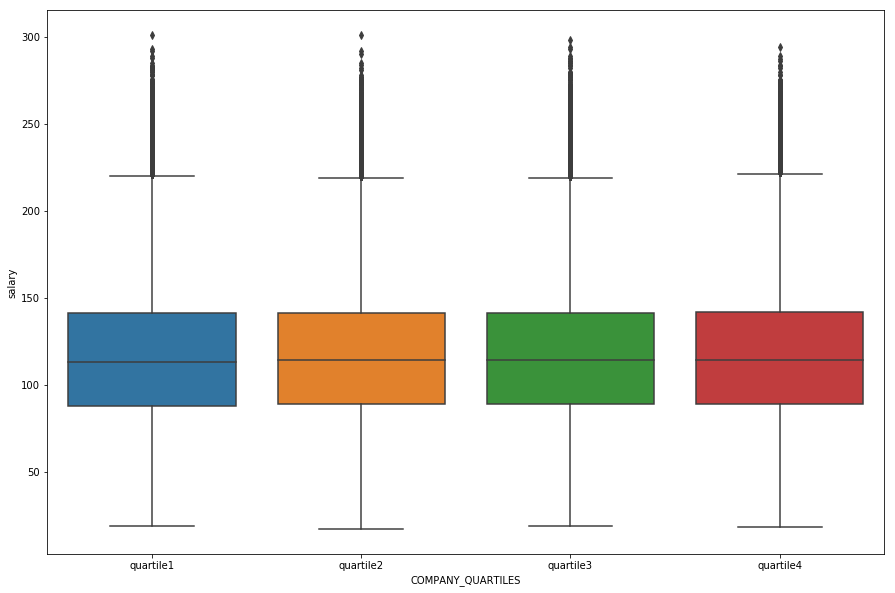

In [0]:
fig = plt.pyplot.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
my_order = train_target_joined.groupby(by=["COMPANY_QUARTILES"])["salary"].median().sort_values(ascending=True).index

ax = sns.boxplot(ax=ax,y='salary',x='COMPANY_QUARTILES',data=train_target_joined,order=my_order)


### What about group statistics? Especially the max of each company group

In [0]:
group_stats = train_target_joined.groupby('companyId')['salary'].describe()
new_columns = ['COMP_'+x for x in group_stats.columns]
group_stats.columns=new_columns
group_stats.head()

,COMP_count,COMP_mean,COMP_std,COMP_min,COMP_25%,COMP_50%,COMP_75%,COMP_max
companyId,,,,,,,,
COMP0,15666.0,115.963615,38.604597,20.0,89.0,114.0,141.0,285.0
COMP1,15820.0,116.048609,38.424871,20.0,89.0,114.0,141.0,292.0
COMP10,15909.0,116.019800,38.782127,24.0,89.0,114.0,141.0,278.0
COMP11,15872.0,116.113029,38.623401,20.0,88.0,114.0,141.0,286.0
COMP12,15783.0,116.086485,38.697106,20.0,89.0,114.0,141.0,281.0


In [0]:
# Use this helper function to grab and join the group stats for each categorical var:
train_features, train_target_joined = engineer_features(train_features, train_salaries, categorical_vars, unique_identifier)

In [0]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,JOBTYPE_CEO,JOBTYPE_CFO,JOBTYPE_CTO,JOBTYPE_JANITOR,JOBTYPE_JUNIOR,JOBTYPE_MANAGER,JOBTYPE_SENIOR,JOBTYPE_VICE_PRESIDENT,MAJOR_BIOLOGY,MAJOR_BUSINESS,MAJOR_CHEMISTRY,MAJOR_COMPSCI,MAJOR_ENGINEERING,MAJOR_LITERATURE,MAJOR_MATH,MAJOR_NONE,MAJOR_PHYSICS,DEGREE_CODE,COMPANY_BIN,COMP_count,COMP_mean,COMP_std,COMP_min,COMP_25%,COMP_50%,COMP_75%,COMP_max,JOBT_count,JOBT_mean,JOBT_std,JOBT_min,JOBT_25%,JOBT_50%,JOBT_75%,JOBT_max,MAJO_count,MAJO_mean,MAJO_std,MAJO_min,MAJO_25%,MAJO_50%,MAJO_75%,MAJO_max,INDU_count,INDU_mean,INDU_std,INDU_min,INDU_25%,INDU_50%,INDU_75%,INDU_max,DEGR_count,DEGR_mean,DEGR_std,DEGR_min,DEGR_25%,DEGR_50%,DEGR_75%,DEGR_max
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,15905.0,115.345049,38.680783,20.0,88.0,113.0,141.0,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,15958.0,115.756548,38.672024,20.0,88.0,113.0,141.0,273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,4,2,15737.0,116.224249,38.641688,19.0,89.0,114.0,141.0,271.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,4,2,15819.0,116.199380,38.843446,19.0,89.0,114.0,141.0,283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,15767.0,115.888501,38.549674,20.0,88.0,114.0,141.0,275.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ---- 8 Create models ----

### Linear Regression

In [0]:
train_features.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'JOBTYPE_CEO', 'JOBTYPE_CFO',
       'JOBTYPE_CTO', 'JOBTYPE_JANITOR', 'JOBTYPE_JUNIOR', 'JOBTYPE_MANAGER',
       'JOBTYPE_SENIOR', 'JOBTYPE_VICE_PRESIDENT', 'MAJOR_BIOLOGY',
       'MAJOR_BUSINESS', 'MAJOR_CHEMISTRY', 'MAJOR_COMPSCI',
       'MAJOR_ENGINEERING', 'MAJOR_LITERATURE', 'MAJOR_MATH', 'MAJOR_NONE',
       'MAJOR_PHYSICS', 'INDUSTRY_AUTO', 'INDUSTRY_EDUCATION',
       'INDUSTRY_FINANCE', 'INDUSTRY_HEALTH', 'INDUSTRY_OIL',
       'INDUSTRY_SERVICE', 'INDUSTRY_WEB', 'DEGREE_CODE', 'COMPANY_BIN',
       'COMP_count', 'COMP_mean', 'COMP_std', 'COMP_min', 'COMP_25%',
       'COMP_50%', 'COMP_75%', 'COMP_max', 'JOBT_count', 'JOBT_mean',
       'JOBT_std', 'JOBT_min', 'JOBT_25%', 'JOBT_50%', 'JOBT_75%', 'JOBT_max',
       'MAJO_count', 'MAJO_mean', 'MAJO_std', 'MAJO_min', 'MAJO_25%',
       'MAJO_50%', 'MAJO_75%', 'MAJO_max', 'INDU_count', 'INDU_mean',
       'IN

In [0]:
original_features = ['yearsExperience', 'milesFromMetropolis', 'JOBTYPE_CEO', 'JOBTYPE_CFO',
       'JOBTYPE_CTO', 'JOBTYPE_JANITOR', 'JOBTYPE_JUNIOR', 'JOBTYPE_MANAGER',
       'JOBTYPE_SENIOR', 'JOBTYPE_VICE_PRESIDENT', 'MAJOR_BIOLOGY',
       'MAJOR_BUSINESS', 'MAJOR_CHEMISTRY', 'MAJOR_COMPSCI',
       'MAJOR_ENGINEERING', 'MAJOR_LITERATURE', 'MAJOR_MATH', 'MAJOR_NONE',
       'MAJOR_PHYSICS', 'INDUSTRY_AUTO', 'INDUSTRY_EDUCATION',
       'INDUSTRY_FINANCE', 'INDUSTRY_HEALTH', 'INDUSTRY_OIL',
       'INDUSTRY_SERVICE', 'INDUSTRY_WEB', 'DEGREE_CODE']
engineered_features = ['COMPANY_BIN', 'COMP_count',
       'COMP_mean', 'COMP_std', 'COMP_min', 'COMP_25%', 'COMP_50%', 'COMP_75%',
       'COMP_max', 'JOBT_count', 'JOBT_mean', 'JOBT_std', 'JOBT_min',
       'JOBT_25%', 'JOBT_50%', 'JOBT_75%', 'JOBT_max', 'MAJO_count',
       'MAJO_mean', 'MAJO_std', 'MAJO_min', 'MAJO_25%', 'MAJO_50%', 'MAJO_75%',
       'MAJO_max', 'INDU_count', 'INDU_mean', 'INDU_std', 'INDU_min',
       'INDU_25%', 'INDU_50%', 'INDU_75%', 'INDU_max', 'DEGR_count',
       'DEGR_mean', 'DEGR_std', 'DEGR_min', 'DEGR_25%', 'DEGR_50%', 'DEGR_75%',
       'DEGR_max']
all_features = original_features + engineered_features

In [0]:
y=train_salaries[target_name].values.reshape(-1, 1)

In [0]:
lm = LinearRegression()
mse, lm = evaluate_model(lm, train_features[original_features], y)
mse

384.59159200319607

In [0]:
# Try with the engineered features:
mse, lm = evaluate_model(lm, train_features[all_features], y)
mse

384.40926454257374

#### Now try with the transformed target:

In [0]:
y=train_salaries['square_root_target']
lm.fit(train_features[original_features],y)
yhat = sk.model_selection.cross_val_predict(lm,train_features[original_features],y,cv=5)
mse = mean_squared_error(y**2,yhat**2)
mse

386.02027329775763

- The target transformation did not help the linear model

### Regularization

In [0]:
# Scale the data
X=train_features[original_features]
scaler = StandardScaler().fit(X)
standardized_X_train = scaler.transform(X)

In [0]:
rdg = sk.linear_model.Ridge()
mse, rdg = evaluate_model(rdg, standardized_X_train, train_salaries[target_name])
mse

384.59133472938242

- this is the same as the unregularized model

In [0]:
# Using Engineered Features:
X=train_features[original_features+engineered_features]
scaler = StandardScaler().fit(X)
standardized_X_train = scaler.transform(X)
mse, rdg = evaluate_model(rdg, standardized_X_train, train_salaries[target_name])
mse

384.41010516376974

- similar to the unregularized version above

In [0]:
rdg = sk.linear_model.Ridge()
y=train_salaries['square_root_target']
rdg.fit(standardized_X_train,y)

yhat = sk.model_selection.cross_val_predict(rdg,standardized_X_train,y,cv=5)
mse = mean_squared_error(y**2,yhat**2)
mse

385.97826136643232

- The target transformation did not help the regularized model

In [0]:
alphas = [0.001,0.1,1, 10, 100]

In [0]:
mse=[]
for ap in alphas:
    rdg = sk.linear_model.Ridge(alpha=ap)
    mse, rdg = evaluate_model(rdg,standardized_X_train,train_salaries[target_name])
    mse.append(mse)

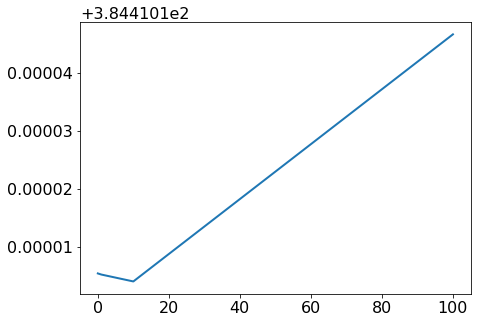

In [0]:
plt.pyplot.plot(alphas,mse);

In [0]:
rdg = sk.linear_model.Ridge(alpha=10)
mse, rdg = evaluate_model(rdg,standardized_X_train,train_salaries[target_name])
mse

384.41010397222618

In [0]:
mse=[]
for ap in alphas:
    ls = Lasso(alpha = ap)
    mse, ls = evaluate_model(ls,standardized_X_train,train_salaries[target_name])
    mse.append(mse)
    
plt.pyplot.plot(alphas,mse)

In [0]:
ls = Lasso(alpha = 0.01) 
mse, ls = evaluate_model(ls,standardized_X_train,train_salaries[target_name])
mse

In [0]:
mse=[]
for ap in alphas:
    en = ElasticNet(alpha = ap)
    mse, en = evaluate_model(en,standardized_X_train,train_salaries[target_name])
    mse.append(mse)
    
plt.pyplot.plot(alphas,mse)

In [0]:
ls = ElasticNet(alpha = 0.1) 
ls.fit(standardized_X_train,y)
yhat = sk.model_selection.cross_val_predict(ls,standardized_X_train,y,cv=5)








### Polynomial Regression

In [0]:
pr = PolynomialFeatures(degree=2)

In [0]:
calcMSE_polynomial(train_features[original_features],train_salaries[target_name])

655.71705940406059

In [0]:
# Using hand-picked features based on correlations in EDA:
X=train_features[np.concatenate((train_features.jobType.unique(),['MAJOR_NONE','yearsExperience','degree_code','milesFromMetropolis']),axis=0)]

calcMSE_polynomial(X,train_salaries[target_name])

505.01761123076892

In [0]:
X=train_features[['JANITOR','CEO','JUNIOR','CTO','CFO','MAJOR_NONE','yearsExperience','degree_code','milesFromMetropolis']]

calcMSE_polynomial(X,train_salaries[target_name])

529.81546723311146

- NOTE: I also tried regularization on polynomial regression but this did not help and is not shown here.

### Random Forest

In [0]:
# Create a sample for hyperparameter tuning since I don't have the resources to use the whole dataset.
X_sample = train_features.set_index(unique_identifier).sample(frac=0.25,random_state=41)

# Get the features
X_sample = X_sample[np.concatenate((train_features.jobType.unique(),major_columns,industry_columns,['yearsExperience','degree_code','milesFromMetropolis']),axis=0)]

#y=train_salaries['salary'].values.reshape(-1, 1)
y_sample = train_salaries.set_index(unique_identifier)['salary'].loc[X_sample.index].values

In [0]:
c,r = y_sample.shape
y_sample = y_sample.reshape(c,)

ValueError: not enough values to unpack (expected 2, got 1)

In [0]:
all_features['']

Index(['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'JOBTYPE_CEO', 'JOBTYPE_CFO',
       'JOBTYPE_CTO', 'JOBTYPE_JANITOR', 'JOBTYPE_JUNIOR', 'JOBTYPE_MANAGER',
       'JOBTYPE_SENIOR', 'JOBTYPE_VICE_PRESIDENT', 'MAJOR_BIOLOGY',
       'MAJOR_BUSINESS', 'MAJOR_CHEMISTRY', 'MAJOR_COMPSCI',
       'MAJOR_ENGINEERING', 'MAJOR_LITERATURE', 'MAJOR_MATH', 'MAJOR_NONE',
       'MAJOR_PHYSICS', 'INDUSTRY_AUTO', 'INDUSTRY_EDUCATION',
       'INDUSTRY_FINANCE', 'INDUSTRY_HEALTH', 'INDUSTRY_OIL',
       'INDUSTRY_SERVICE', 'INDUSTRY_WEB', 'DEGREE_CODE', 'COMPANY_BIN',
       'COMP_count', 'COMP_mean', 'COMP_std', 'COMP_min', 'COMP_25%',
       'COMP_50%', 'COMP_75%', 'COMP_max', 'JOBT_count', 'JOBT_mean',
       'JOBT_std', 'JOBT_min', 'JOBT_25%', 'JOBT_50%', 'JOBT_75%', 'JOBT_max',
       'MAJO_count', 'MAJO_mean', 'MAJO_std', 'MAJO_min', 'MAJO_25%',
       'MAJO_50%', 'MAJO_75%', 'MAJO_max', 'INDU_count', 'INDU_mean',
       'INDU_std', 

In [0]:
rf = RandomForestRegressor(oob_score=True,random_state=55,n_estimators=10,max_depth=100,max_features='auto',min_samples_leaf=3)
mse, rf = evaluate_model(rf,train_features[all_features],train_salaries[target_name])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

In [0]:
mse

405.87464214884625

In [0]:
rf.oob_score_

0.5923277435355798

In [0]:
#### Look at max_depth:
max_depth_size  = [1,2,3,4,5,10,20,50,100]


In [0]:
oob_scores = evaluate_rf_hyperparams('max_depth', max_depth_size, train_features[all_features], train_salaries[target_name])

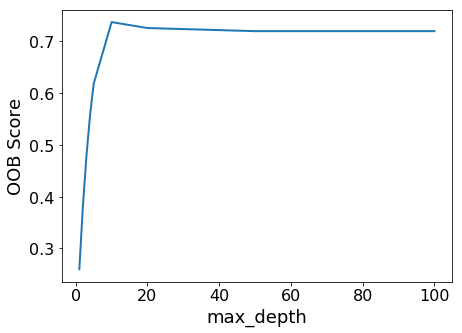

In [0]:
plot_oob('max_depth',max_depth_size,oob_scores)

In [0]:
oob_scores.index(max(oob_scores))

5

In [0]:
best_max_depth = max_depth_size[5]
best_max_depth

10

In [0]:
#### Look at n_estimators:
n_trees = [1, 2, 3, 4, 5, 15, 20, 25, 40, 50]
oob_scores = evaluate_rf_hyperparams('n_estimators', n_trees, train_features[all_features], train_salaries[target_name])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

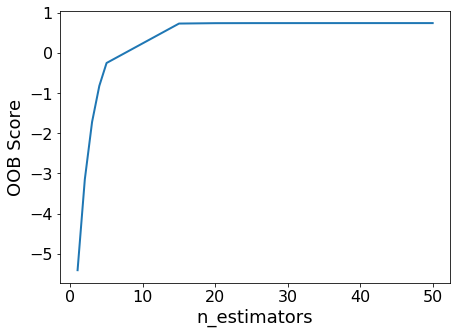

In [0]:
plot_oob('n_estimators',n_trees,oob_scores)

In [0]:
print("highest oob:",max(oob_scores))
print("oob for 15 trees",oob_scores[5])
print("oob for 20 trees",oob_scores[6])

highest oob: 0.7395366679113525
oob for 15 trees 0.7278729617884891
oob for 20 trees 0.737364507910048


In [0]:
best_n_trees = 20

In [0]:
#### Look at max_features:
max_features_options = ["auto", None, "sqrt", "log2", 0.7, 0.2]
oob_scores = evaluate_rf_hyperparams('max_features', max_features_options, train_features[all_features], train_salaries[target_name])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

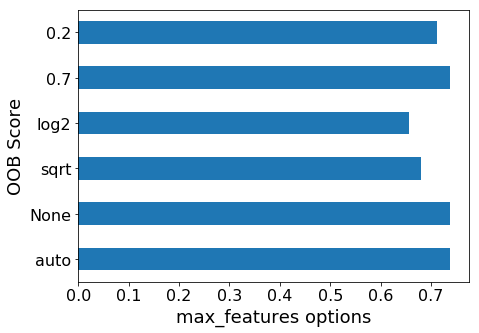

In [0]:
pd.Series(oob_scores, max_features_options).plot(kind='barh')
plt.pyplot.xlabel('max_features options');
plt.pyplot.ylabel('OOB Score');
plt.pyplot.show()

In [0]:
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]


In [0]:
oob_scores = evaluate_rf_hyperparams('min_samples_leaf', min_samples_leaf_options, train_features[all_features], train_salaries[target_name])

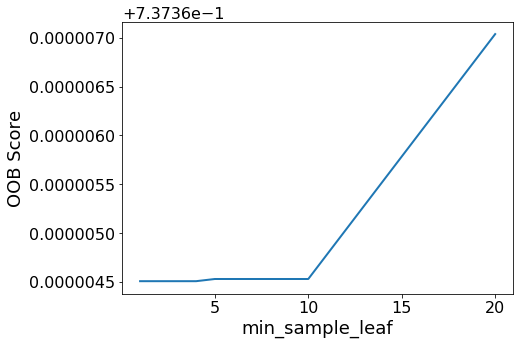

In [0]:
plot_oob('min_sample_leaf',min_samples_leaf_options,oob_scores)

In [0]:
oob_scores[9]

0.737364530268011

In [0]:
oob_scores[10]

0.737367038368035

In [0]:
best_min_samples_leaf = min_samples_leaf_options[9]

In [0]:
rf = RandomForestRegressor(oob_score=True, n_jobs=-1,random_state=55,n_estimators=best_n_trees,max_depth=best_max_depth,max_features='auto',min_samples_leaf=best_min_samples_leaf)
mse, rf = evaluate_model(rf,train_features[all_features],train_salaries[target_name])
mse

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

390.2676004648628

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.189684 to fit



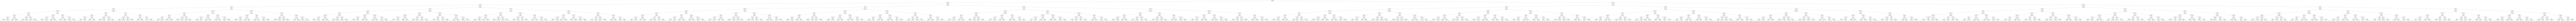

In [0]:

# Visualize tree
from IPython.display import Image  
from sklearn import tree
import pydotplus


# Create DOT data
dot_data = tree.export_graphviz(rf.estimators_[0], out_file=None, 
                                feature_names=train_features[all_features].columns,  
                                class_names=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [0]:
rf.base_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

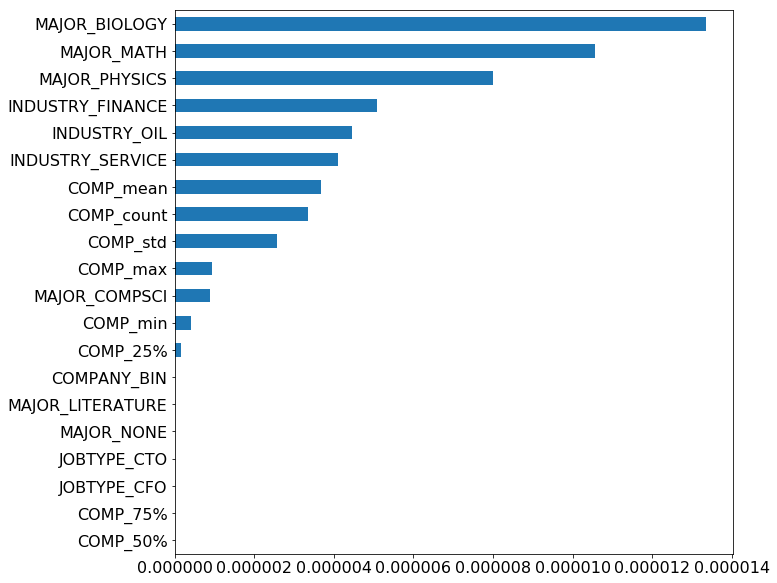

In [0]:
#### Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=train_features[all_features].columns)
feature_importances.sort_values(inplace=True)

feature_importances.head(20).plot(kind='barh', figsize=(10,10));

### Gradient Boosting

In [0]:
results = []
for max_depth in [2,3,4,5,10,12,15]:
  booster = xgb.XGBRegressor(max_depth=max_depth)   
  mse, booster = evaluate_model(booster,train_features[all_features],train_salaries[target_name])  
  results.append(mse)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:00:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [0]:

results = []
#2,3,4,5,10,12,15
for max_depth in [15]:
  gb = GradientBoostingRegressor(max_depth=max_depth)
  mse, booster = evaluate_model(gb,train_features[all_features],train_salaries[target_name])  
  results.append(mse)


In [0]:
     
plt.pyplot.plot(max_depth, results);
plt.pyplot.xlabel("Max Depth");
plt.pyplot.ylabel('MSE');

In [0]:
plt.pyplot.show()

NameError: ignored

In [0]:
# USE WHEN GOES TO PRODUCTION

params = {"alpha": [0.001,0.1,1, 10, 100, 1000, 10000, 100000]}
grid = GridSearchCV(estimator=rdg, param_grid=params,cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

//anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.743436887194561
1


### ---- 10 Select best model  ----

In [0]:
#select the model with the lowest error as your "prodcuction" model

#DEPLOY

### ---- 11 Automate pipeline ----

In [0]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset
def train_model(model,X,y,pickle_fname):
  model.fit(X,y)

  # Save model to disk
  with open (pickle_fname,'wb') as file:
    pickle.dump(model,file)

def load_model(pickle_fname):
  # Load model that was saved to disk
  with open (pickle_fname,'rb') as file:
    pickled_model = pickle.load(file)
  return pickled_model

def score_test_set(model,X,predictions_fname):
  yhat = model.predict(X)

  # Save predictions to disk
  with open (predictions_fname,'w') as file:
      csv_writer = csv.writer(csvfile)
      csv_writer.write(yhat)

   


In [0]:

uploaded = files.upload()

Saving train_salaries.csv to train_salaries (1).csv
Saving train_features.csv to train_features (1).csv


In [0]:
train_features, test_features, train_salaries = load_data('train_features.csv','test_features.csv','train_salaries.csv')

In [0]:
# Don't want to dummy encode the company variable, so use nominal-vars[1:]
nominal_vars_to_encode = nominal_vars[1:] # Leave out companyId
train_data, base_features, engineered_features, train_salaries, train_target_joined = preprocess_data(train_features, train_salaries, target_name, categorical_vars, nominal_vars_to_encode, ordinal_vars, unique_identifier)

In [0]:
test_data,  = preprocess_data(test_features, , , categorical_vars, nominal_vars_to_encode, ordinal_vars, unique_identifier)

In [0]:
features_to_model = base_features.union(engineered_features) - {'companyId'}
train_features = select_features_to_model(train_data, list(features_to_model))

In [0]:
gb = GradientBoostingRegressor(max_depth=2,subsample=0.1)

In [0]:
pickle_fname = 'trained_model.pkl'
train_model(gb,train_features,train_salaries[target_name],pickle_fname)


In [0]:
gb = load_model(pickle_fname)

In [37]:
  yhat = gb.predict(test_features)

ValueError: ignored

In [39]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [0]:
score_test_set(gb, test_features, 'salary_predictions.csv')

### ---- 12 Deploy solution ----

In [0]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data